In [9]:
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/")
!pwd

/gpfs/milgram/pi/turk-browne/projects/rtTest


In [13]:
from subprocess import call
import subprocess
# call("squeue -u kp578 | wc -l",shell=True)
# !squeue -u kp578 | wc -l
subprocess.Popen(['squeue -u kp578 | wc -l > squeue.txt'],shell=True) # sl_result = Class(_runs, bcvar)
numberOfJobsRunning = int(open("squeue.txt", "r").read())
if numberOfJobsRunning > 100:
    time.sleep(100)

In [26]:
subject = "0111171"
N = 40

roiloc = "schaefer2018"
dataSource = "neurosketch"
os.path.exists(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{39}.pkl")

True

In [4]:
'''
purpose:
    according to the given number of ROIs N, pick up the top N ROIs accuracy and combine them for a combined mask and retrain the model and getting result

steps:
    load accuracy for all the ROIs for given subject
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

    get the N combinations of N-1 ROIs
    retrain the model and get the accuracy for these N combinations

    get the N-1 combinations of N-2 ROIs
    retrain the model and get the accuracy for these N-1 combinations

'''
'''
you could try to see whether combining parcels improves performance. 
That's going to be the most important bit, because we'll want to decide on a tradeoff between number of voxels and accuracy. 
The script of interest here is aggregate.sh which is just a feeder for aggregate.py. 
This will use the .npy outputs of classRegion.py to select and merge the top N ROIs/parcels, and will return the list of ROI names, the number of voxels, and the cross-validated classifier accuracy 
in this newly combined larger mask. An example run of this is as follows:
sbatch aggregate.sh 0111171 neurosketch schaefer2018 15
'''
import numpy as np
import nibabel as nib
import os
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression

# What subject are you running
'''
Takes args (in order):
    subject (e.g. 0111171)
    dataSource (e.g. neurosketch, but also realtime)
    roiloc (wang2014 or schaefer2018)
    N (the number of parcels or ROIs to start with)
'''
subject = "0111171"
N = 38

try:
    roiloc = "schaefer2018"
    print("Using user-selected roi location: {}".format(roiloc))
except:
    print("NO ROI LOCATION ENTERED: Using roi location of wang2014")
    roiloc = "wang2014"

try:
    dataSource = "neurosketch"
    print("Using {} data".format(dataSource))
except:
    print("NO DATASOURCE ENTERED: Using original neurosketch data")
    dataSource = 'neurosketch'

print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(subject, dataSource, roiloc, N))


# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"
    
starttime = time.time()

outloc = "./{}/{}/output".format(roiloc, subject)

if roiloc == "schaefer2018":
    topN = []
    for roinum in range(1,301):
        result = np.load("{}/{}.npy".format(outloc, roinum))
        RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    # select N ROIs
    RESULTix = RESULT[:,0].argsort()[-N:] #argsort from small to big
    for idx in RESULTix:
        topN.append("{}.nii.gz".format(idx+1))
        print(topN[-1])
else:
    topN = []
    for hemi in ["lh", "rh"]:
        for roinum in range(1, 26):
            result = np.load("{}/roi{}_{}.npy".format(outloc, roinum, hemi))
            Result = result if roinum == 1 else np.vstack((Result, result))
        RESULT = Result if hemi == "lh" else np.hstack((RESULT, Result))

    RESULT1d = RESULT.flatten()
    RESULTix = RESULT1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(RESULTix, RESULT.shape)

    # Check that we got the largest values.
    for x, y, in zip(x_idx, y_idx):
        print(x,y)
        if y == 0:
            topN.append("roi{}_lh.nii.gz".format(x+1))
        else:
            topN.append("roi{}_rh.nii.gz".format(x+1))
        print(topN[-1])


def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))
        
def normalize(X):
    X = X - X.mean(3)
    return X

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[run])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

for pn, parc in enumerate(topN):
    _mask = nib.load("./{}/{}/{}".format(roiloc, subject, parc))
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
    mask[mask>0] = 1
print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))

Using user-selected roi location: schaefer2018
Using neurosketch data
Running subject 0111171, with neurosketch as a data source, schaefer2018, starting with 38 ROIs
270.nii.gz
161.nii.gz
2.nii.gz
31.nii.gz
261.nii.gz
26.nii.gz
78.nii.gz
63.nii.gz
23.nii.gz
223.nii.gz
155.nii.gz
121.nii.gz
204.nii.gz
246.nii.gz
240.nii.gz
60.nii.gz
47.nii.gz
258.nii.gz
235.nii.gz
89.nii.gz
62.nii.gz
44.nii.gz
27.nii.gz
10.nii.gz
71.nii.gz
280.nii.gz
15.nii.gz
58.nii.gz
248.nii.gz
13.nii.gz
279.nii.gz
253.nii.gz
113.nii.gz
243.nii.gz
135.nii.gz
165.nii.gz
84.nii.gz
220.nii.gz


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:155: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


mask dimensions: (94, 94, 72)
number of voxels in mask: 14155


In [71]:
# Compile preprocessed data and corresponding indices
metas = []

for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_data()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
#     features = features[:, mask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
#     featmean = features.mean(1)[..., None]
    featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    features = features - featmean
    features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    metas.append(labels)
    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()



1--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
2--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
3--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
4--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
5--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
6--LENGTH OF TR: 80


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
Runs shape (6, 80, 94, 94, 72)
(6, 80, 94, 94, 72)
shape of data: (6, 80, 94, 94, 72)


In [78]:
# Preset the variables

bcvar = [metas]
                 
# Distribute the information to the searchlights (preparing it to run)
_runs = [runs[:,:,mask==1]]
print("Runs shape", _runs[0].shape)
slstart = time.time()
sl_result = Class(_runs, bcvar)


# Distribute the information to the searchlights (preparing it to run)


# _runs = runs[:,:,mask==1]
# slstart = time.time()
# sl_result = Class(data, bcvar)

# print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))

# SL = time.time() - slstart
# tot = time.time() - starttime
#     print('total time: {}, searchlight time: {}'.format(tot, SL))

Runs shape (6, 80, 14155)
(6, 80, 14155)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

(6, 80, 94, 94, 72)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


ValueError: Found array with dim 4. Estimator expected <= 2.

In [86]:
import pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
# N-1
allpairs = itertools.combinations(topN,len(topN)-1)
topNs=[]
sl_results=[]
tmpFiles=[]
for _topN in tqdm(allpairs):
    topNs.append(_topN)
    _mask=getMask(_topN)
    # np.save(tmpFile,_mask)
    _runs = [runs[:,:,_mask==1]]

#     print('mask dimensions: {}'. format(_mask.shape))
#     print('number of voxels in mask: {}'.format(np.sum(_mask)))
#     print("Runs shape", _runs[0].shape)

    tmpFile=f"./tmp/{time.time()}"
    save_obj([_runs,bcvar], tmpFile)
    tmpFiles.append(tmpFile)

0it [00:00, ?it/s]/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys
14it [00:09,  1.52it/s]


KeyboardInterrupt: 

In [121]:
def wait(tmpFile):
    while not os.path.exists(tmpFile+'_result.npy'):
        time.sleep(5)
        print("waiting\n")
    return np.load(tmpFile+'_result.npy')
def next(topN):
    if len(topN)==1:
        return None
    else:
#         try:
        allpairs = itertools.combinations(topN,len(topN)-1)
        topNs=[]
        sl_results=[]
        tmpFiles=[]
        for i,_topN in tqdm(enumerate(allpairs)):
            topNs.append(_topN)
            _mask=getMask(_topN)
            # np.save(tmpFile,_mask)
            _runs = [runs[:,:,_mask==1]]

            print('mask dimensions: {}'. format(_mask.shape))
            print('number of voxels in mask: {}'.format(np.sum(_mask)))
            print("Runs shape", _runs[0].shape)

            tmpFile=f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}_{i}"
            save_obj([_runs,bcvar], tmpFile)
            tmpFiles.append(tmpFile)
            if not os.path.exists(tmpFile+'_result.npy'):
                proc = subprocess.Popen([f'sbatch class.sh {tmpFile}'],shell=True) # sl_result = Class(_runs, bcvar)
        sl_results=[]
        for tmpFile in tmpFiles:
            sl_result=wait(tmpFile)
            sl_results.append(sl_result)
        print(f"sl_results={sl_results}")
        print(f"max(sl_results)=={max(sl_results)}")
        maxID=np.where(sl_results==max(sl_results))[0][0]
        save_obj({"subject":subject,
        "startFromN":N,
        "currNumberOfROI":len(topN)-1,
        "bestAcc":max(sl_results),
        "bestROIs":topNs[maxID]},
        f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}"
        )
        print(f"bestAccFor {len(topN)-1} = ./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}")
        next(topNs[maxID])
#         except:
#             return tmpFiles
tmpFiles=next(topN)

0it [00:00, ?it/s]/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys
1it [00:00,  1.30it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13780
Runs shape (6, 80, 13780)


2it [00:01,  1.46it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13901
Runs shape (6, 80, 13901)


3it [00:02,  1.49it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13609
Runs shape (6, 80, 13609)


4it [00:02,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13403
Runs shape (6, 80, 13403)


5it [00:03,  1.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13515
Runs shape (6, 80, 13515)


6it [00:03,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13162
Runs shape (6, 80, 13162)


7it [00:04,  1.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13670
Runs shape (6, 80, 13670)


8it [00:05,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 14041
Runs shape (6, 80, 14041)


9it [00:05,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13797
Runs shape (6, 80, 13797)


10it [00:06,  1.62it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13824
Runs shape (6, 80, 13824)


11it [00:07,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13772
Runs shape (6, 80, 13772)


12it [00:07,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13523
Runs shape (6, 80, 13523)


13it [00:08,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13770
Runs shape (6, 80, 13770)


14it [00:08,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13806
Runs shape (6, 80, 13806)


15it [00:09,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13917
Runs shape (6, 80, 13917)


16it [00:10,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 14023
Runs shape (6, 80, 14023)


17it [00:10,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13905
Runs shape (6, 80, 13905)


18it [00:11,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13841
Runs shape (6, 80, 13841)


19it [00:12,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13574
Runs shape (6, 80, 13574)


20it [00:12,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13950
Runs shape (6, 80, 13950)


21it [00:13,  1.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13696
Runs shape (6, 80, 13696)


22it [00:14,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13865
Runs shape (6, 80, 13865)


23it [00:14,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 14039
Runs shape (6, 80, 14039)


24it [00:15,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13850
Runs shape (6, 80, 13850)


25it [00:15,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13657
Runs shape (6, 80, 13657)


26it [00:16,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13837
Runs shape (6, 80, 13837)


27it [00:17,  1.54it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13767
Runs shape (6, 80, 13767)


28it [00:17,  1.55it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 14059
Runs shape (6, 80, 14059)


29it [00:18,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13863
Runs shape (6, 80, 13863)


30it [00:19,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13793
Runs shape (6, 80, 13793)


31it [00:19,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13710
Runs shape (6, 80, 13710)


32it [00:20,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13993
Runs shape (6, 80, 13993)


33it [00:21,  1.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13632
Runs shape (6, 80, 13632)


34it [00:21,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13759
Runs shape (6, 80, 13759)


35it [00:22,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13908
Runs shape (6, 80, 13908)


36it [00:22,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13728
Runs shape (6, 80, 13728)


37it [00:23,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13913
Runs shape (6, 80, 13913)


38it [00:24,  1.57it/s]
0it [00:00, ?it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13883
Runs shape (6, 80, 13883)
sl_results=[array(0.29375), array(0.29375), array(0.28333333), array(0.27708333), array(0.27291667), array(0.29375), array(0.29166667), array(0.27708333), array(0.2875), array(0.28125), array(0.29166667), array(0.2875), array(0.30416667), array(0.28541667), array(0.28958333), array(0.29166667), array(0.2875), array(0.27708333), array(0.2875), array(0.2875), array(0.29583333), array(0.27916667), array(0.29166667), array(0.29166667), array(0.28958333), array(0.27916667), array(0.28958333), array(0.3), array(0.30416667), array(0.29166667), array(0.28333333), array(0.28541667), array(0.27291667), array(0.3), array(0.29375), array(0.27708333), array(0.275), array(0.29375)]
max(sl_results)==0.3041666666666667
bestAccFor 37 = ./tmp/0111171_38_schaefer2018_neurosketch_37


1it [00:00,  1.77it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13395
Runs shape (6, 80, 13395)


2it [00:01,  1.66it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13516
Runs shape (6, 80, 13516)


3it [00:01,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13224
Runs shape (6, 80, 13224)


4it [00:02,  1.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13018
Runs shape (6, 80, 13018)


5it [00:03,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13130
Runs shape (6, 80, 13130)


6it [00:03,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12777
Runs shape (6, 80, 12777)


7it [00:04,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13285
Runs shape (6, 80, 13285)


8it [00:04,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13656
Runs shape (6, 80, 13656)


9it [00:05,  1.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13412
Runs shape (6, 80, 13412)


10it [00:06,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13439
Runs shape (6, 80, 13439)


11it [00:06,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13387
Runs shape (6, 80, 13387)


12it [00:07,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13138
Runs shape (6, 80, 13138)


13it [00:08,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13421
Runs shape (6, 80, 13421)


14it [00:08,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13532
Runs shape (6, 80, 13532)


15it [00:09,  1.55it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13638
Runs shape (6, 80, 13638)


16it [00:10,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13520
Runs shape (6, 80, 13520)


17it [00:10,  1.55it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13456
Runs shape (6, 80, 13456)


18it [00:11,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13189
Runs shape (6, 80, 13189)


19it [00:12,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13565
Runs shape (6, 80, 13565)


20it [00:12,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13311
Runs shape (6, 80, 13311)


21it [00:13,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13480
Runs shape (6, 80, 13480)


22it [00:13,  1.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13654
Runs shape (6, 80, 13654)


23it [00:14,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13465
Runs shape (6, 80, 13465)


24it [00:15,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13272
Runs shape (6, 80, 13272)


25it [00:15,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13452
Runs shape (6, 80, 13452)


26it [00:16,  1.55it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13382
Runs shape (6, 80, 13382)


27it [00:17,  1.54it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13674
Runs shape (6, 80, 13674)


28it [00:17,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13478
Runs shape (6, 80, 13478)


29it [00:18,  1.55it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13408
Runs shape (6, 80, 13408)


30it [00:19,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13325
Runs shape (6, 80, 13325)


31it [00:19,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13608
Runs shape (6, 80, 13608)


32it [00:20,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13247
Runs shape (6, 80, 13247)


33it [00:20,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13374
Runs shape (6, 80, 13374)


34it [00:21,  1.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13523
Runs shape (6, 80, 13523)


35it [00:22,  1.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13343
Runs shape (6, 80, 13343)


36it [00:22,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13528
Runs shape (6, 80, 13528)


37it [00:23,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13498
Runs shape (6, 80, 13498)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.275), array(0.30625), array(0.2875), array(0.2875), array(0.28541667), array(0.29791667), array(0.29583333), array(0.28958333), array(0.3), array(0.29375), array(0.28125), array(0.29375), array(0.28958333), array(0.28958333), array(0.3), array(0.30625), array(0.2875), array(0.29583333), array(0.30208333), array(0.28541667), array(0.27916667), array(0.29375), array(0.29583333), array(0.29166667), array(0.3), array(0.30208333), array(0.30208333), array(0.30208333), array(0.29375), array(0.29166667), array(0.29375), array(0.3), array(0.29166667), array(0.28541667), array(0.2875), array(0.2875), array(0.3)]
max(sl_results)==0.30624999999999997
bestAccFor 36 = ./tmp/0111171_38_schaefer2018_neurosketch_36


1it [00:00,  1.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13141
Runs shape (6, 80, 13141)


2it [00:01,  1.43it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12970
Runs shape (6, 80, 12970)


3it [00:02,  1.50it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12764
Runs shape (6, 80, 12764)


4it [00:02,  1.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12876
Runs shape (6, 80, 12876)


5it [00:03,  1.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12523
Runs shape (6, 80, 12523)


6it [00:03,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13031
Runs shape (6, 80, 13031)


7it [00:04,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13402
Runs shape (6, 80, 13402)


8it [00:05,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13158
Runs shape (6, 80, 13158)


9it [00:05,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13185
Runs shape (6, 80, 13185)


10it [00:06,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13133
Runs shape (6, 80, 13133)


11it [00:06,  1.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12884
Runs shape (6, 80, 12884)


12it [00:07,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13167
Runs shape (6, 80, 13167)


13it [00:08,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13278
Runs shape (6, 80, 13278)


14it [00:08,  1.64it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13384
Runs shape (6, 80, 13384)


15it [00:09,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13266
Runs shape (6, 80, 13266)


16it [00:10,  1.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13202
Runs shape (6, 80, 13202)


17it [00:10,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12935
Runs shape (6, 80, 12935)


18it [00:11,  1.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13311
Runs shape (6, 80, 13311)


19it [00:11,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13057
Runs shape (6, 80, 13057)


20it [00:12,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13226
Runs shape (6, 80, 13226)


21it [00:13,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13400
Runs shape (6, 80, 13400)


22it [00:13,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13211
Runs shape (6, 80, 13211)


23it [00:14,  1.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13018
Runs shape (6, 80, 13018)


24it [00:15,  1.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13198
Runs shape (6, 80, 13198)


25it [00:15,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13128
Runs shape (6, 80, 13128)


26it [00:16,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13420
Runs shape (6, 80, 13420)


27it [00:16,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13224
Runs shape (6, 80, 13224)


28it [00:17,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13154
Runs shape (6, 80, 13154)


29it [00:18,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13071
Runs shape (6, 80, 13071)


30it [00:18,  1.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13354
Runs shape (6, 80, 13354)


31it [00:19,  1.62it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12993
Runs shape (6, 80, 12993)


32it [00:20,  1.62it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13120
Runs shape (6, 80, 13120)


33it [00:20,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13269
Runs shape (6, 80, 13269)


34it [00:21,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13089
Runs shape (6, 80, 13089)


35it [00:21,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13274
Runs shape (6, 80, 13274)


36it [00:22,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13244
Runs shape (6, 80, 13244)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.28958333), array(0.2875), array(0.275), array(0.27916667), array(0.29166667), array(0.29791667), array(0.28333333), array(0.29583333), array(0.29375), array(0.2875), array(0.28333333), array(0.28541667), array(0.29791667), array(0.29375), array(0.2875), array(0.29166667), array(0.29583333), array(0.2875), array(0.2875), array(0.28125), array(0.28958333), array(0.3), array(0.29166667), array(0.28958333), array(0.30625), array(0.30208333), array(0.30208333), array(0.2875), array(0.2875), array(0.28958333), array(0.28958333), array(0.28958333), array(0.29375), array(0.29166667), array(0.29375), array(0.29166667)]
max(sl_results)==0.30624999999999997
bestAccFor 35 = ./tmp/0111171_38_schaefer2018_neurosketch_35


1it [00:00,  1.33it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12753
Runs shape (6, 80, 12753)


2it [00:01,  1.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12582
Runs shape (6, 80, 12582)


3it [00:01,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12376
Runs shape (6, 80, 12376)


4it [00:02,  1.66it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12488
Runs shape (6, 80, 12488)


5it [00:03,  1.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12135
Runs shape (6, 80, 12135)


6it [00:03,  1.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12643
Runs shape (6, 80, 12643)


7it [00:04,  1.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13014
Runs shape (6, 80, 13014)


8it [00:04,  1.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12770
Runs shape (6, 80, 12770)


9it [00:05,  1.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12797
Runs shape (6, 80, 12797)


10it [00:06,  1.70it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12745
Runs shape (6, 80, 12745)


11it [00:06,  1.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12496
Runs shape (6, 80, 12496)


12it [00:07,  1.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12779
Runs shape (6, 80, 12779)


13it [00:07,  1.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12890
Runs shape (6, 80, 12890)


14it [00:08,  1.66it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12996
Runs shape (6, 80, 12996)


15it [00:09,  1.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12878
Runs shape (6, 80, 12878)


16it [00:09,  1.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12814
Runs shape (6, 80, 12814)


17it [00:10,  1.70it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12547
Runs shape (6, 80, 12547)


18it [00:10,  1.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12923
Runs shape (6, 80, 12923)


19it [00:11,  1.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12669
Runs shape (6, 80, 12669)


20it [00:12,  1.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12838
Runs shape (6, 80, 12838)


21it [00:12,  1.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13012
Runs shape (6, 80, 13012)


22it [00:13,  1.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12823
Runs shape (6, 80, 12823)


23it [00:13,  1.70it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12630
Runs shape (6, 80, 12630)


24it [00:14,  1.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12810
Runs shape (6, 80, 12810)


25it [00:14,  1.72it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 13032
Runs shape (6, 80, 13032)


26it [00:15,  1.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12836
Runs shape (6, 80, 12836)
mask dimensions: (94, 94, 72)
number of voxels in mask: 12766
Runs shape (6, 80, 12766)


28it [00:16,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12683
Runs shape (6, 80, 12683)


29it [00:17,  1.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12966
Runs shape (6, 80, 12966)


30it [00:18,  1.62it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12605
Runs shape (6, 80, 12605)


31it [00:18,  1.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12732
Runs shape (6, 80, 12732)


32it [00:19,  1.64it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12881
Runs shape (6, 80, 12881)


33it [00:19,  1.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12701
Runs shape (6, 80, 12701)


34it [00:20,  1.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12886
Runs shape (6, 80, 12886)


35it [00:21,  1.66it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12856
Runs shape (6, 80, 12856)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.3), array(0.28958333), array(0.27708333), array(0.28958333), array(0.29583333), array(0.3), array(0.29583333), array(0.29791667), array(0.29375), array(0.27708333), array(0.29375), array(0.29583333), array(0.29375), array(0.3), array(0.28958333), array(0.29375), array(0.30833333), array(0.2875), array(0.29791667), array(0.28958333), array(0.30208333), array(0.3), array(0.31041667), array(0.29166667), array(0.29583333), array(0.3), array(0.28958333), array(0.30208333), array(0.3), array(0.3), array(0.3125), array(0.28958333), array(0.29166667), array(0.29791667), array(0.3)]
max(sl_results)==0.3125
bestAccFor 34 = ./tmp/0111171_38_schaefer2018_neurosketch_34


1it [00:00,  1.41it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12357
Runs shape (6, 80, 12357)


2it [00:01,  1.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12186
Runs shape (6, 80, 12186)


3it [00:01,  1.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11980
Runs shape (6, 80, 11980)


4it [00:02,  1.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12092
Runs shape (6, 80, 12092)


5it [00:02,  1.76it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11739
Runs shape (6, 80, 11739)


6it [00:03,  1.76it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12247
Runs shape (6, 80, 12247)


7it [00:04,  1.72it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12618
Runs shape (6, 80, 12618)


8it [00:04,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12374
Runs shape (6, 80, 12374)


9it [00:05,  1.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12401
Runs shape (6, 80, 12401)


10it [00:05,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12349
Runs shape (6, 80, 12349)


11it [00:06,  1.75it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12100
Runs shape (6, 80, 12100)


12it [00:06,  1.72it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12383
Runs shape (6, 80, 12383)


13it [00:07,  1.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12494
Runs shape (6, 80, 12494)


14it [00:08,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12600
Runs shape (6, 80, 12600)


15it [00:08,  1.72it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12482
Runs shape (6, 80, 12482)


16it [00:09,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12418
Runs shape (6, 80, 12418)


17it [00:09,  1.76it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12151
Runs shape (6, 80, 12151)


18it [00:10,  1.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12527
Runs shape (6, 80, 12527)


19it [00:11,  1.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12273
Runs shape (6, 80, 12273)


20it [00:11,  1.72it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12442
Runs shape (6, 80, 12442)


21it [00:12,  1.72it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12616
Runs shape (6, 80, 12616)


22it [00:12,  1.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12427
Runs shape (6, 80, 12427)


23it [00:13,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12234
Runs shape (6, 80, 12234)


24it [00:13,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12414
Runs shape (6, 80, 12414)


25it [00:14,  1.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12636
Runs shape (6, 80, 12636)


26it [00:15,  1.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12440
Runs shape (6, 80, 12440)


27it [00:15,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12370
Runs shape (6, 80, 12370)


28it [00:16,  1.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12287
Runs shape (6, 80, 12287)


29it [00:16,  1.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12570
Runs shape (6, 80, 12570)


30it [00:17,  1.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12209
Runs shape (6, 80, 12209)


31it [00:17,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12485
Runs shape (6, 80, 12485)


32it [00:18,  1.72it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12305
Runs shape (6, 80, 12305)


33it [00:19,  1.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12490
Runs shape (6, 80, 12490)


34it [00:19,  1.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12460
Runs shape (6, 80, 12460)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.28958333), array(0.28958333), array(0.28333333), array(0.28333333), array(0.30208333), array(0.30833333), array(0.29583333), array(0.28958333), array(0.28333333), array(0.29791667), array(0.29375), array(0.29791667), array(0.29583333), array(0.29583333), array(0.3), array(0.28958333), array(0.31041667), array(0.29791667), array(0.29583333), array(0.29375), array(0.29583333), array(0.3), array(0.30208333), array(0.29791667), array(0.29375), array(0.30625), array(0.29791667), array(0.28958333), array(0.2875), array(0.28541667), array(0.28958333), array(0.30208333), array(0.3), array(0.28958333)]
max(sl_results)==0.3104166666666667
bestAccFor 33 = ./tmp/0111171_38_schaefer2018_neurosketch_33


1it [00:00,  1.36it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11776
Runs shape (6, 80, 11776)


2it [00:01,  1.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11605
Runs shape (6, 80, 11605)


3it [00:01,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11399
Runs shape (6, 80, 11399)


4it [00:02,  1.75it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11511
Runs shape (6, 80, 11511)


5it [00:02,  1.79it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11158
Runs shape (6, 80, 11158)


6it [00:03,  1.79it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11666
Runs shape (6, 80, 11666)


7it [00:04,  1.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12037
Runs shape (6, 80, 12037)


8it [00:04,  1.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11793
Runs shape (6, 80, 11793)


9it [00:05,  1.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11820
Runs shape (6, 80, 11820)


10it [00:05,  1.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11768
Runs shape (6, 80, 11768)


11it [00:06,  1.86it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11519
Runs shape (6, 80, 11519)


12it [00:06,  1.87it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11802
Runs shape (6, 80, 11802)


13it [00:07,  1.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11913
Runs shape (6, 80, 11913)


14it [00:07,  1.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12019
Runs shape (6, 80, 12019)


15it [00:08,  1.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11901
Runs shape (6, 80, 11901)


16it [00:08,  1.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11837
Runs shape (6, 80, 11837)


17it [00:09,  1.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11946
Runs shape (6, 80, 11946)


18it [00:10,  1.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11692
Runs shape (6, 80, 11692)


19it [00:10,  1.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11861
Runs shape (6, 80, 11861)


20it [00:11,  1.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12035
Runs shape (6, 80, 12035)


21it [00:11,  1.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11846
Runs shape (6, 80, 11846)


22it [00:12,  1.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11653
Runs shape (6, 80, 11653)


23it [00:12,  1.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11833
Runs shape (6, 80, 11833)


24it [00:13,  1.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 12055
Runs shape (6, 80, 12055)


25it [00:13,  1.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11859
Runs shape (6, 80, 11859)


26it [00:14,  1.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11789
Runs shape (6, 80, 11789)


27it [00:14,  1.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11706
Runs shape (6, 80, 11706)


28it [00:15,  1.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11989
Runs shape (6, 80, 11989)


29it [00:16,  1.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11628
Runs shape (6, 80, 11628)


30it [00:16,  1.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11904
Runs shape (6, 80, 11904)


31it [00:17,  1.79it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11724
Runs shape (6, 80, 11724)


32it [00:17,  1.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11909
Runs shape (6, 80, 11909)


33it [00:18,  1.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11879
Runs shape (6, 80, 11879)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.29791667), array(0.29583333), array(0.27916667), array(0.275), array(0.29583333), array(0.30416667), array(0.30416667), array(0.30416667), array(0.29166667), array(0.29166667), array(0.29583333), array(0.30416667), array(0.30833333), array(0.30833333), array(0.2875), array(0.29583333), array(0.30208333), array(0.30833333), array(0.3), array(0.29583333), array(0.29583333), array(0.30625), array(0.30208333), array(0.30208333), array(0.30416667), array(0.30416667), array(0.30208333), array(0.30208333), array(0.29375), array(0.30833333), array(0.30416667), array(0.28333333), array(0.29375)]
max(sl_results)==0.30833333333333335
bestAccFor 32 = ./tmp/0111171_38_schaefer2018_neurosketch_32


1it [00:00,  1.46it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11538
Runs shape (6, 80, 11538)


2it [00:01,  1.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11367
Runs shape (6, 80, 11367)


3it [00:01,  1.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11161
Runs shape (6, 80, 11161)


4it [00:02,  1.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11273
Runs shape (6, 80, 11273)


5it [00:02,  1.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10920
Runs shape (6, 80, 10920)


6it [00:03,  1.86it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11428
Runs shape (6, 80, 11428)


7it [00:03,  1.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11799
Runs shape (6, 80, 11799)


8it [00:04,  1.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11555
Runs shape (6, 80, 11555)


9it [00:04,  1.88it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11582
Runs shape (6, 80, 11582)


10it [00:05,  1.87it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11530
Runs shape (6, 80, 11530)


11it [00:05,  1.90it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11281
Runs shape (6, 80, 11281)


12it [00:06,  1.90it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11564
Runs shape (6, 80, 11564)


13it [00:07,  1.88it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11781
Runs shape (6, 80, 11781)


14it [00:07,  1.88it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11663
Runs shape (6, 80, 11663)


15it [00:08,  1.88it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11599
Runs shape (6, 80, 11599)


16it [00:08,  1.87it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11708
Runs shape (6, 80, 11708)


17it [00:09,  1.85it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11454
Runs shape (6, 80, 11454)


18it [00:09,  1.85it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11623
Runs shape (6, 80, 11623)


19it [00:10,  1.87it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11797
Runs shape (6, 80, 11797)


20it [00:10,  1.85it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11608
Runs shape (6, 80, 11608)


21it [00:11,  1.85it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11415
Runs shape (6, 80, 11415)


22it [00:11,  1.88it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11595
Runs shape (6, 80, 11595)


23it [00:12,  1.87it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11817
Runs shape (6, 80, 11817)


24it [00:12,  1.87it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11621
Runs shape (6, 80, 11621)


25it [00:13,  1.88it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11551
Runs shape (6, 80, 11551)


26it [00:14,  1.86it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11468
Runs shape (6, 80, 11468)


27it [00:14,  1.86it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11751
Runs shape (6, 80, 11751)


28it [00:15,  1.86it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11390
Runs shape (6, 80, 11390)


29it [00:15,  1.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11666
Runs shape (6, 80, 11666)


30it [00:16,  1.85it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11486
Runs shape (6, 80, 11486)


31it [00:16,  1.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11671
Runs shape (6, 80, 11671)


32it [00:17,  1.85it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11641
Runs shape (6, 80, 11641)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.30208333), array(0.3), array(0.28333333), array(0.27708333), array(0.28333333), array(0.29166667), array(0.3), array(0.31666667), array(0.30208333), array(0.30625), array(0.29375), array(0.29791667), array(0.31875), array(0.30416667), array(0.31041667), array(0.325), array(0.3125), array(0.31041667), array(0.30208333), array(0.30416667), array(0.29791667), array(0.29375), array(0.31666667), array(0.3125), array(0.30416667), array(0.31041667), array(0.29583333), array(0.3), array(0.30416667), array(0.30833333), array(0.30416667), array(0.30625)]
max(sl_results)==0.325
bestAccFor 31 = ./tmp/0111171_38_schaefer2018_neurosketch_31


1it [00:00,  1.45it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11333
Runs shape (6, 80, 11333)


2it [00:01,  1.70it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11162
Runs shape (6, 80, 11162)


3it [00:01,  1.77it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10956
Runs shape (6, 80, 10956)


4it [00:02,  1.86it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11068
Runs shape (6, 80, 11068)


5it [00:02,  1.90it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10715
Runs shape (6, 80, 10715)


6it [00:03,  1.90it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11223
Runs shape (6, 80, 11223)


7it [00:03,  1.89it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11594
Runs shape (6, 80, 11594)


8it [00:04,  1.89it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11350
Runs shape (6, 80, 11350)


9it [00:04,  1.88it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11377
Runs shape (6, 80, 11377)


10it [00:05,  1.90it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11325
Runs shape (6, 80, 11325)


11it [00:05,  1.90it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11076
Runs shape (6, 80, 11076)


12it [00:06,  1.91it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11359
Runs shape (6, 80, 11359)


13it [00:06,  1.89it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11576
Runs shape (6, 80, 11576)


14it [00:07,  1.91it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11458
Runs shape (6, 80, 11458)


15it [00:07,  1.93it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11394
Runs shape (6, 80, 11394)


16it [00:08,  1.92it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11249
Runs shape (6, 80, 11249)


17it [00:09,  1.89it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11418
Runs shape (6, 80, 11418)


18it [00:09,  1.91it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11592
Runs shape (6, 80, 11592)


19it [00:10,  1.89it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11403
Runs shape (6, 80, 11403)


20it [00:10,  1.91it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11210
Runs shape (6, 80, 11210)


21it [00:11,  1.93it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11390
Runs shape (6, 80, 11390)


22it [00:11,  1.91it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11612
Runs shape (6, 80, 11612)


23it [00:12,  1.92it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11416
Runs shape (6, 80, 11416)


24it [00:12,  1.93it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11346
Runs shape (6, 80, 11346)


25it [00:13,  1.91it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11263
Runs shape (6, 80, 11263)


26it [00:13,  1.91it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11546
Runs shape (6, 80, 11546)


27it [00:14,  1.90it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11185
Runs shape (6, 80, 11185)


28it [00:15,  1.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11461
Runs shape (6, 80, 11461)


29it [00:15,  1.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11281
Runs shape (6, 80, 11281)


30it [00:16,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11466
Runs shape (6, 80, 11466)


31it [00:16,  1.85it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11436
Runs shape (6, 80, 11436)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.30416667), array(0.29166667), array(0.29166667), array(0.29166667), array(0.30208333), array(0.30833333), array(0.29583333), array(0.30833333), array(0.3125), array(0.30625), array(0.28958333), array(0.29583333), array(0.31458333), array(0.30625), array(0.30416667), array(0.29791667), array(0.30416667), array(0.3), array(0.32083333), array(0.30416667), array(0.31041667), array(0.30625), array(0.3), array(0.32291667), array(0.30208333), array(0.30833333), array(0.29375), array(0.31041667), array(0.28958333), array(0.30208333), array(0.30208333)]
max(sl_results)==0.3229166666666667
bestAccFor 30 = ./tmp/0111171_38_schaefer2018_neurosketch_30


1it [00:00,  1.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10971
Runs shape (6, 80, 10971)


2it [00:01,  1.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10800
Runs shape (6, 80, 10800)


3it [00:01,  1.86it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10594
Runs shape (6, 80, 10594)


4it [00:02,  1.94it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10706
Runs shape (6, 80, 10706)


5it [00:02,  1.94it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10353
Runs shape (6, 80, 10353)


6it [00:03,  1.94it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10861
Runs shape (6, 80, 10861)


7it [00:03,  1.98it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11232
Runs shape (6, 80, 11232)


8it [00:04,  1.95it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10988
Runs shape (6, 80, 10988)


9it [00:04,  1.98it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11015
Runs shape (6, 80, 11015)


10it [00:05,  1.96it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10963
Runs shape (6, 80, 10963)


11it [00:05,  1.97it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10714
Runs shape (6, 80, 10714)


12it [00:06,  2.00it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10997
Runs shape (6, 80, 10997)


13it [00:06,  1.94it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11214
Runs shape (6, 80, 11214)


14it [00:07,  1.96it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11096
Runs shape (6, 80, 11096)


15it [00:07,  1.97it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11032
Runs shape (6, 80, 11032)


16it [00:08,  1.96it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10887
Runs shape (6, 80, 10887)


17it [00:08,  1.98it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11056
Runs shape (6, 80, 11056)


18it [00:09,  1.96it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11230
Runs shape (6, 80, 11230)


19it [00:09,  1.93it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11041
Runs shape (6, 80, 11041)


20it [00:10,  1.96it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10848
Runs shape (6, 80, 10848)


21it [00:10,  1.94it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11028
Runs shape (6, 80, 11028)


22it [00:11,  1.97it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11250
Runs shape (6, 80, 11250)


23it [00:11,  1.97it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11054
Runs shape (6, 80, 11054)


24it [00:12,  1.95it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10901
Runs shape (6, 80, 10901)


25it [00:12,  1.98it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11184
Runs shape (6, 80, 11184)


26it [00:13,  1.95it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10823
Runs shape (6, 80, 10823)


27it [00:13,  1.94it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11099
Runs shape (6, 80, 11099)


28it [00:14,  1.96it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10919
Runs shape (6, 80, 10919)


29it [00:14,  1.94it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11104
Runs shape (6, 80, 11104)


30it [00:15,  1.95it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 11074
Runs shape (6, 80, 11074)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.30208333), array(0.29791667), array(0.29791667), array(0.28958333), array(0.28541667), array(0.30416667), array(0.30625), array(0.3125), array(0.3), array(0.30833333), array(0.29166667), array(0.30416667), array(0.3125), array(0.30833333), array(0.31041667), array(0.31875), array(0.30416667), array(0.29375), array(0.30416667), array(0.30833333), array(0.30416667), array(0.31875), array(0.31041667), array(0.31458333), array(0.31458333), array(0.30625), array(0.31666667), array(0.30625), array(0.29375), array(0.3)]
max(sl_results)==0.31875000000000003
bestAccFor 29 = ./tmp/0111171_38_schaefer2018_neurosketch_29


1it [00:00,  1.49it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10512
Runs shape (6, 80, 10512)


2it [00:01,  1.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10341
Runs shape (6, 80, 10341)


3it [00:01,  1.92it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10135
Runs shape (6, 80, 10135)


4it [00:02,  1.97it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10247
Runs shape (6, 80, 10247)


5it [00:02,  2.02it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9894
Runs shape (6, 80, 9894)


6it [00:03,  1.99it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10402
Runs shape (6, 80, 10402)


7it [00:03,  2.01it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10773
Runs shape (6, 80, 10773)


8it [00:04,  2.00it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10529
Runs shape (6, 80, 10529)


9it [00:04,  1.98it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10556
Runs shape (6, 80, 10556)


10it [00:05,  2.02it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10504
Runs shape (6, 80, 10504)


11it [00:05,  2.02it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10255
Runs shape (6, 80, 10255)


12it [00:06,  2.00it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10538
Runs shape (6, 80, 10538)


13it [00:06,  2.00it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10755
Runs shape (6, 80, 10755)


14it [00:07,  1.99it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10637
Runs shape (6, 80, 10637)


15it [00:07,  2.02it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10573
Runs shape (6, 80, 10573)


16it [00:08,  2.02it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10597
Runs shape (6, 80, 10597)


17it [00:08,  2.02it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10771
Runs shape (6, 80, 10771)


18it [00:09,  2.05it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10582
Runs shape (6, 80, 10582)


19it [00:09,  2.06it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10389
Runs shape (6, 80, 10389)


20it [00:10,  2.06it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10569
Runs shape (6, 80, 10569)


21it [00:10,  2.05it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10791
Runs shape (6, 80, 10791)
mask dimensions: (94, 94, 72)
number of voxels in mask: 10595
Runs shape (6, 80, 10595)


23it [00:11,  1.98it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10442
Runs shape (6, 80, 10442)


24it [00:12,  1.99it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10725
Runs shape (6, 80, 10725)


25it [00:12,  2.02it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10364
Runs shape (6, 80, 10364)


26it [00:13,  2.01it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10640
Runs shape (6, 80, 10640)


27it [00:13,  2.01it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10460
Runs shape (6, 80, 10460)


28it [00:14,  1.99it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10645
Runs shape (6, 80, 10645)


29it [00:14,  1.99it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10615
Runs shape (6, 80, 10615)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.30625), array(0.30416667), array(0.30416667), array(0.28958333), array(0.30208333), array(0.29583333), array(0.30416667), array(0.31041667), array(0.31875), array(0.30208333), array(0.30416667), array(0.3125), array(0.31041667), array(0.31875), array(0.30833333), array(0.30625), array(0.31041667), array(0.30833333), array(0.30625), array(0.30416667), array(0.31458333), array(0.30833333), array(0.30208333), array(0.31041667), array(0.30416667), array(0.3), array(0.31875), array(0.30208333), array(0.31666667)]
max(sl_results)==0.31875000000000003
bestAccFor 28 = ./tmp/0111171_38_schaefer2018_neurosketch_28


1it [00:00,  1.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10262
Runs shape (6, 80, 10262)


2it [00:01,  1.89it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10091
Runs shape (6, 80, 10091)


3it [00:01,  1.99it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9885
Runs shape (6, 80, 9885)


4it [00:02,  1.99it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9997
Runs shape (6, 80, 9997)


5it [00:02,  2.04it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9644
Runs shape (6, 80, 9644)


6it [00:03,  2.05it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10152
Runs shape (6, 80, 10152)


7it [00:03,  2.04it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10523
Runs shape (6, 80, 10523)


8it [00:04,  2.03it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10279
Runs shape (6, 80, 10279)


9it [00:04,  2.07it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10306
Runs shape (6, 80, 10306)


10it [00:04,  2.07it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10254
Runs shape (6, 80, 10254)


11it [00:05,  2.07it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10005
Runs shape (6, 80, 10005)


12it [00:05,  2.10it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10288
Runs shape (6, 80, 10288)


13it [00:06,  2.07it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10505
Runs shape (6, 80, 10505)


14it [00:06,  2.04it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10323
Runs shape (6, 80, 10323)
mask dimensions: (94, 94, 72)
number of voxels in mask: 10347
Runs shape (6, 80, 10347)


16it [00:08,  1.78it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10521
Runs shape (6, 80, 10521)


17it [00:08,  1.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10332
Runs shape (6, 80, 10332)


18it [00:09,  1.90it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10139
Runs shape (6, 80, 10139)


19it [00:09,  1.95it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10319
Runs shape (6, 80, 10319)


20it [00:10,  1.96it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10541
Runs shape (6, 80, 10541)


21it [00:10,  2.03it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10345
Runs shape (6, 80, 10345)


22it [00:11,  2.02it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10192
Runs shape (6, 80, 10192)


23it [00:11,  2.02it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10475
Runs shape (6, 80, 10475)


24it [00:12,  2.04it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10114
Runs shape (6, 80, 10114)


25it [00:12,  2.04it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10390
Runs shape (6, 80, 10390)


26it [00:13,  2.07it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10210
Runs shape (6, 80, 10210)


27it [00:13,  2.07it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10395
Runs shape (6, 80, 10395)


28it [00:14,  1.99it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10365
Runs shape (6, 80, 10365)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.31875), array(0.3125), array(0.30833333), array(0.28958333), array(0.30625), array(0.3125), array(0.3125), array(0.32083333), array(0.30625), array(0.30625), array(0.28541667), array(0.30625), array(0.32083333), array(0.3125), array(0.30208333), array(0.30833333), array(0.32083333), array(0.30625), array(0.32291667), array(0.31458333), array(0.30416667), array(0.3125), array(0.31458333), array(0.29166667), array(0.3125), array(0.31041667), array(0.3), array(0.31666667)]
max(sl_results)==0.3229166666666667
bestAccFor 27 = ./tmp/0111171_38_schaefer2018_neurosketch_27


1it [00:00,  1.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9944
Runs shape (6, 80, 9944)


2it [00:01,  1.87it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9773
Runs shape (6, 80, 9773)


3it [00:01,  2.00it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9567
Runs shape (6, 80, 9567)


4it [00:02,  2.07it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9679
Runs shape (6, 80, 9679)


5it [00:02,  2.15it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9326
Runs shape (6, 80, 9326)


6it [00:02,  2.14it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9834
Runs shape (6, 80, 9834)


7it [00:03,  2.11it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10205
Runs shape (6, 80, 10205)


8it [00:03,  2.08it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9961
Runs shape (6, 80, 9961)


9it [00:04,  2.13it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9988
Runs shape (6, 80, 9988)


10it [00:04,  2.12it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9936
Runs shape (6, 80, 9936)


11it [00:05,  2.15it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9687
Runs shape (6, 80, 9687)


12it [00:05,  2.15it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9970
Runs shape (6, 80, 9970)


13it [00:06,  2.17it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10187
Runs shape (6, 80, 10187)


14it [00:06,  2.12it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10005
Runs shape (6, 80, 10005)


15it [00:07,  2.14it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10029
Runs shape (6, 80, 10029)


16it [00:07,  2.13it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10203
Runs shape (6, 80, 10203)


17it [00:08,  2.13it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10014
Runs shape (6, 80, 10014)


18it [00:08,  2.14it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9821
Runs shape (6, 80, 9821)


19it [00:09,  2.11it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10223
Runs shape (6, 80, 10223)


20it [00:09,  2.12it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10027
Runs shape (6, 80, 10027)


21it [00:09,  2.11it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9874
Runs shape (6, 80, 9874)


22it [00:10,  2.14it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10157
Runs shape (6, 80, 10157)


23it [00:10,  2.14it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9796
Runs shape (6, 80, 9796)


24it [00:11,  2.16it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10072
Runs shape (6, 80, 10072)


25it [00:11,  2.16it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9892
Runs shape (6, 80, 9892)


26it [00:12,  2.17it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10077
Runs shape (6, 80, 10077)


27it [00:12,  2.12it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10047
Runs shape (6, 80, 10047)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.29583333), array(0.29791667), array(0.30416667), array(0.3), array(0.30208333), array(0.31666667), array(0.30208333), array(0.31875), array(0.30625), array(0.31041667), array(0.3), array(0.29583333), array(0.31041667), array(0.30208333), array(0.31041667), array(0.31458333), array(0.31666667), array(0.3125), array(0.32083333), array(0.30625), array(0.30833333), array(0.30208333), array(0.29791667), array(0.3125), array(0.30625), array(0.30833333), array(0.31041667)]
max(sl_results)==0.32083333333333336
bestAccFor 26 = ./tmp/0111171_38_schaefer2018_neurosketch_26


1it [00:00,  1.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9848
Runs shape (6, 80, 9848)


2it [00:01,  2.00it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9677
Runs shape (6, 80, 9677)


3it [00:01,  2.14it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9471
Runs shape (6, 80, 9471)


4it [00:01,  2.12it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9583
Runs shape (6, 80, 9583)


5it [00:02,  2.16it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9230
Runs shape (6, 80, 9230)


6it [00:02,  2.19it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9738
Runs shape (6, 80, 9738)


7it [00:03,  2.16it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10109
Runs shape (6, 80, 10109)


8it [00:03,  2.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9865
Runs shape (6, 80, 9865)


9it [00:04,  2.18it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9892
Runs shape (6, 80, 9892)


10it [00:04,  2.15it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9840
Runs shape (6, 80, 9840)


11it [00:05,  2.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9591
Runs shape (6, 80, 9591)


12it [00:05,  2.18it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9874
Runs shape (6, 80, 9874)


13it [00:06,  2.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10091
Runs shape (6, 80, 10091)


14it [00:06,  2.19it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9909
Runs shape (6, 80, 9909)


15it [00:06,  2.22it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9933
Runs shape (6, 80, 9933)


16it [00:07,  2.22it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10107
Runs shape (6, 80, 10107)


17it [00:07,  2.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9918
Runs shape (6, 80, 9918)


18it [00:08,  2.17it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9725
Runs shape (6, 80, 9725)


19it [00:08,  2.16it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9931
Runs shape (6, 80, 9931)


20it [00:09,  2.19it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9778
Runs shape (6, 80, 9778)


21it [00:09,  2.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 10061
Runs shape (6, 80, 10061)


22it [00:10,  2.21it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9700
Runs shape (6, 80, 9700)


23it [00:10,  2.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9976
Runs shape (6, 80, 9976)


24it [00:11,  2.22it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9796
Runs shape (6, 80, 9796)


25it [00:11,  2.22it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9981
Runs shape (6, 80, 9981)


26it [00:11,  2.18it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9951
Runs shape (6, 80, 9951)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.28333333), array(0.3125), array(0.30625), array(0.2875), array(0.29791667), array(0.32083333), array(0.29583333), array(0.31041667), array(0.30416667), array(0.31041667), array(0.3), array(0.29375), array(0.31458333), array(0.30208333), array(0.29791667), array(0.30208333), array(0.30416667), array(0.30625), array(0.30833333), array(0.30833333), array(0.30625), array(0.30208333), array(0.31041667), array(0.30833333), array(0.30833333), array(0.3)]
max(sl_results)==0.3208333333333333
bestAccFor 25 = ./tmp/0111171_38_schaefer2018_neurosketch_25


1it [00:00,  1.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9363
Runs shape (6, 80, 9363)


2it [00:01,  1.94it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9192
Runs shape (6, 80, 9192)


3it [00:01,  2.05it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8986
Runs shape (6, 80, 8986)


4it [00:01,  2.18it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9098
Runs shape (6, 80, 9098)


5it [00:02,  2.24it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8745
Runs shape (6, 80, 8745)


6it [00:02,  2.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9624
Runs shape (6, 80, 9624)


7it [00:03,  2.23it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9380
Runs shape (6, 80, 9380)


8it [00:03,  2.28it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9407
Runs shape (6, 80, 9407)


9it [00:04,  2.26it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9355
Runs shape (6, 80, 9355)


10it [00:04,  2.31it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9106
Runs shape (6, 80, 9106)


11it [00:04,  2.26it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9389
Runs shape (6, 80, 9389)


12it [00:05,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9606
Runs shape (6, 80, 9606)


13it [00:05,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9424
Runs shape (6, 80, 9424)


14it [00:06,  2.25it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9448
Runs shape (6, 80, 9448)


15it [00:06,  2.30it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9622
Runs shape (6, 80, 9622)


16it [00:07,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9433
Runs shape (6, 80, 9433)


17it [00:07,  2.33it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9240
Runs shape (6, 80, 9240)


18it [00:08,  2.33it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9446
Runs shape (6, 80, 9446)


19it [00:08,  2.28it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9293
Runs shape (6, 80, 9293)


20it [00:08,  2.31it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9576
Runs shape (6, 80, 9576)


21it [00:09,  2.31it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9215
Runs shape (6, 80, 9215)


22it [00:09,  2.28it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9491
Runs shape (6, 80, 9491)


23it [00:10,  2.30it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9311
Runs shape (6, 80, 9311)


24it [00:10,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9496
Runs shape (6, 80, 9496)


25it [00:11,  2.25it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9466
Runs shape (6, 80, 9466)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.31458333), array(0.30208333), array(0.29791667), array(0.3), array(0.31458333), array(0.3), array(0.31041667), array(0.31458333), array(0.3), array(0.30208333), array(0.3125), array(0.31666667), array(0.30416667), array(0.31041667), array(0.31458333), array(0.29791667), array(0.30208333), array(0.325), array(0.31458333), array(0.30208333), array(0.30416667), array(0.3125), array(0.31875), array(0.30833333), array(0.31458333)]
max(sl_results)==0.325
bestAccFor 24 = ./tmp/0111171_38_schaefer2018_neurosketch_24


1it [00:00,  1.70it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9071
Runs shape (6, 80, 9071)


2it [00:01,  2.04it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8900
Runs shape (6, 80, 8900)


3it [00:01,  2.26it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8694
Runs shape (6, 80, 8694)


4it [00:01,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8806
Runs shape (6, 80, 8806)


5it [00:02,  2.38it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8453
Runs shape (6, 80, 8453)


6it [00:02,  2.44it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9332
Runs shape (6, 80, 9332)


7it [00:03,  2.38it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9088
Runs shape (6, 80, 9088)


8it [00:03,  2.38it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9115
Runs shape (6, 80, 9115)


9it [00:03,  2.40it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9063
Runs shape (6, 80, 9063)


10it [00:04,  2.40it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8814
Runs shape (6, 80, 8814)


11it [00:04,  2.38it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9097
Runs shape (6, 80, 9097)


12it [00:05,  2.32it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9314
Runs shape (6, 80, 9314)


13it [00:05,  2.34it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9132
Runs shape (6, 80, 9132)


14it [00:06,  2.37it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9156
Runs shape (6, 80, 9156)


15it [00:06,  2.41it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9330
Runs shape (6, 80, 9330)


16it [00:06,  2.41it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9141
Runs shape (6, 80, 9141)


17it [00:07,  2.41it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8948
Runs shape (6, 80, 8948)


18it [00:07,  2.43it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9001
Runs shape (6, 80, 9001)


19it [00:08,  2.39it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9284
Runs shape (6, 80, 9284)


20it [00:08,  2.44it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8923
Runs shape (6, 80, 8923)


21it [00:08,  2.43it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9199
Runs shape (6, 80, 9199)


22it [00:09,  2.39it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9019
Runs shape (6, 80, 9019)


23it [00:09,  2.40it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9204
Runs shape (6, 80, 9204)


24it [00:10,  2.36it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9174
Runs shape (6, 80, 9174)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.31458333), array(0.32083333), array(0.29166667), array(0.30833333), array(0.31458333), array(0.30833333), array(0.32083333), array(0.32291667), array(0.3125), array(0.30833333), array(0.31041667), array(0.32291667), array(0.31458333), array(0.30208333), array(0.30416667), array(0.31875), array(0.30625), array(0.31458333), array(0.31666667), array(0.3125), array(0.31666667), array(0.31666667), array(0.32083333), array(0.31875)]
max(sl_results)==0.3229166666666667
bestAccFor 23 = ./tmp/0111171_38_schaefer2018_neurosketch_23


1it [00:00,  1.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8740
Runs shape (6, 80, 8740)


2it [00:01,  1.98it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8569
Runs shape (6, 80, 8569)


3it [00:01,  2.15it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8363
Runs shape (6, 80, 8363)


4it [00:01,  2.10it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8475
Runs shape (6, 80, 8475)


5it [00:02,  2.18it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8122
Runs shape (6, 80, 8122)


6it [00:02,  2.08it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 9001
Runs shape (6, 80, 9001)


7it [00:03,  2.10it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8757
Runs shape (6, 80, 8757)


8it [00:03,  2.15it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8732
Runs shape (6, 80, 8732)


9it [00:04,  2.18it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8483
Runs shape (6, 80, 8483)


10it [00:04,  2.18it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8766
Runs shape (6, 80, 8766)


11it [00:05,  2.23it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8983
Runs shape (6, 80, 8983)


12it [00:05,  2.26it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8801
Runs shape (6, 80, 8801)


13it [00:05,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8825
Runs shape (6, 80, 8825)


14it [00:06,  2.27it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8999
Runs shape (6, 80, 8999)


15it [00:06,  2.22it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8810
Runs shape (6, 80, 8810)


16it [00:07,  2.21it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8617
Runs shape (6, 80, 8617)


17it [00:07,  2.11it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8670
Runs shape (6, 80, 8670)


18it [00:08,  2.13it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8953
Runs shape (6, 80, 8953)


19it [00:08,  2.11it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8592
Runs shape (6, 80, 8592)


20it [00:09,  2.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8868
Runs shape (6, 80, 8868)


21it [00:09,  2.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8688
Runs shape (6, 80, 8688)


22it [00:10,  2.23it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8873
Runs shape (6, 80, 8873)


23it [00:10,  2.17it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8843
Runs shape (6, 80, 8843)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.30625), array(0.31458333), array(0.29791667), array(0.3125), array(0.29583333), array(0.3125), array(0.32083333), array(0.31875), array(0.31666667), array(0.31875), array(0.32291667), array(0.32083333), array(0.3), array(0.30833333), array(0.32916667), array(0.31458333), array(0.31666667), array(0.32083333), array(0.30416667), array(0.30833333), array(0.32083333), array(0.32291667), array(0.30416667)]
max(sl_results)==0.32916666666666666
bestAccFor 22 = ./tmp/0111171_38_schaefer2018_neurosketch_22


1it [00:00,  1.76it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8435
Runs shape (6, 80, 8435)


2it [00:00,  2.12it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8264
Runs shape (6, 80, 8264)


3it [00:01,  2.28it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8058
Runs shape (6, 80, 8058)


4it [00:01,  2.36it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8170
Runs shape (6, 80, 8170)


5it [00:02,  2.46it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7817
Runs shape (6, 80, 7817)


6it [00:02,  2.50it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8696
Runs shape (6, 80, 8696)


7it [00:02,  2.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8452
Runs shape (6, 80, 8452)


8it [00:03,  2.55it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8427
Runs shape (6, 80, 8427)


9it [00:03,  2.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8178
Runs shape (6, 80, 8178)


10it [00:04,  2.51it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8461
Runs shape (6, 80, 8461)


11it [00:04,  2.51it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8678
Runs shape (6, 80, 8678)


12it [00:04,  2.47it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8496
Runs shape (6, 80, 8496)


13it [00:05,  2.49it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8520
Runs shape (6, 80, 8520)


14it [00:05,  2.51it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8694
Runs shape (6, 80, 8694)


15it [00:06,  2.47it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8312
Runs shape (6, 80, 8312)


16it [00:06,  2.51it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8365
Runs shape (6, 80, 8365)


17it [00:06,  2.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8648
Runs shape (6, 80, 8648)


18it [00:07,  2.51it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8287
Runs shape (6, 80, 8287)


19it [00:07,  2.49it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8563
Runs shape (6, 80, 8563)


20it [00:08,  2.48it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8383
Runs shape (6, 80, 8383)


21it [00:08,  2.49it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8568
Runs shape (6, 80, 8568)


22it [00:08,  2.47it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8538
Runs shape (6, 80, 8538)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.30625), array(0.31041667), array(0.30416667), array(0.30833333), array(0.30625), array(0.31458333), array(0.32291667), array(0.30416667), array(0.3125), array(0.32291667), array(0.31666667), array(0.31458333), array(0.30208333), array(0.3125), array(0.30625), array(0.31041667), array(0.30625), array(0.31458333), array(0.31875), array(0.31041667), array(0.31875), array(0.31875)]
max(sl_results)==0.3229166666666667
bestAccFor 21 = ./tmp/0111171_38_schaefer2018_neurosketch_21


1it [00:00,  1.93it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8077
Runs shape (6, 80, 8077)


2it [00:00,  2.31it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7906
Runs shape (6, 80, 7906)


3it [00:01,  2.50it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7700
Runs shape (6, 80, 7700)


4it [00:01,  2.55it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7812
Runs shape (6, 80, 7812)


5it [00:01,  2.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7459
Runs shape (6, 80, 7459)


6it [00:02,  2.62it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8338
Runs shape (6, 80, 8338)


7it [00:02,  2.62it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8069
Runs shape (6, 80, 8069)


8it [00:03,  2.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7820
Runs shape (6, 80, 7820)


9it [00:03,  2.66it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8103
Runs shape (6, 80, 8103)


10it [00:03,  2.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8320
Runs shape (6, 80, 8320)


11it [00:04,  2.66it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8138
Runs shape (6, 80, 8138)


12it [00:04,  2.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8162
Runs shape (6, 80, 8162)


13it [00:05,  2.66it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8336
Runs shape (6, 80, 8336)


14it [00:05,  2.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7954
Runs shape (6, 80, 7954)


15it [00:05,  2.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8007
Runs shape (6, 80, 8007)


16it [00:06,  2.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8290
Runs shape (6, 80, 8290)


17it [00:06,  2.66it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7929
Runs shape (6, 80, 7929)


18it [00:06,  2.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8205
Runs shape (6, 80, 8205)


19it [00:07,  2.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8025
Runs shape (6, 80, 8025)


20it [00:07,  2.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8210
Runs shape (6, 80, 8210)


21it [00:08,  2.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8180
Runs shape (6, 80, 8180)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

w

0it [00:00, ?it/s]

waiting

sl_results=[array(0.32291667), array(0.325), array(0.29583333), array(0.31875), array(0.31041667), array(0.32083333), array(0.32916667), array(0.31041667), array(0.31666667), array(0.31666667), array(0.31875), array(0.31041667), array(0.31041667), array(0.31875), array(0.31875), array(0.31666667), array(0.31041667), array(0.32291667), array(0.30416667), array(0.32083333), array(0.32916667)]
max(sl_results)==0.32916666666666666
bestAccFor 20 = ./tmp/0111171_38_schaefer2018_neurosketch_20


1it [00:00,  1.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7805
Runs shape (6, 80, 7805)


2it [00:00,  2.09it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7634
Runs shape (6, 80, 7634)


3it [00:01,  2.19it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7428
Runs shape (6, 80, 7428)


4it [00:01,  2.25it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7540
Runs shape (6, 80, 7540)


5it [00:02,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7187
Runs shape (6, 80, 7187)


6it [00:02,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8066
Runs shape (6, 80, 8066)


7it [00:03,  2.31it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7797
Runs shape (6, 80, 7797)


8it [00:03,  2.33it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7548
Runs shape (6, 80, 7548)


9it [00:03,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7831
Runs shape (6, 80, 7831)


10it [00:04,  2.27it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8048
Runs shape (6, 80, 8048)


11it [00:04,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7866
Runs shape (6, 80, 7866)


12it [00:05,  2.28it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7890
Runs shape (6, 80, 7890)


13it [00:05,  2.23it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8064
Runs shape (6, 80, 8064)


14it [00:06,  2.26it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7682
Runs shape (6, 80, 7682)


15it [00:06,  2.28it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7735
Runs shape (6, 80, 7735)


16it [00:07,  2.30it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 8018
Runs shape (6, 80, 8018)


17it [00:07,  2.31it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7657
Runs shape (6, 80, 7657)


18it [00:07,  2.25it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7933
Runs shape (6, 80, 7933)


19it [00:08,  2.25it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7753
Runs shape (6, 80, 7753)


20it [00:08,  2.26it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7938
Runs shape (6, 80, 7938)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

w

0it [00:00, ?it/s]

waiting

sl_results=[array(0.31041667), array(0.31666667), array(0.31875), array(0.31458333), array(0.32083333), array(0.3125), array(0.32291667), array(0.32083333), array(0.30833333), array(0.30833333), array(0.3125), array(0.31666667), array(0.3125), array(0.32083333), array(0.31458333), array(0.32083333), array(0.31666667), array(0.31041667), array(0.31666667), array(0.3125)]
max(sl_results)==0.3229166666666667
bestAccFor 19 = ./tmp/0111171_38_schaefer2018_neurosketch_19


1it [00:00,  2.14it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7422
Runs shape (6, 80, 7422)


2it [00:00,  2.41it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7251
Runs shape (6, 80, 7251)


3it [00:01,  2.54it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7045
Runs shape (6, 80, 7045)


4it [00:01,  2.52it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7157
Runs shape (6, 80, 7157)


5it [00:01,  2.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6804
Runs shape (6, 80, 6804)


6it [00:02,  2.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7683
Runs shape (6, 80, 7683)


7it [00:02,  2.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7165
Runs shape (6, 80, 7165)


8it [00:03,  2.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7448
Runs shape (6, 80, 7448)


9it [00:03,  2.50it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7665
Runs shape (6, 80, 7665)


10it [00:03,  2.54it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7483
Runs shape (6, 80, 7483)


11it [00:04,  2.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7507
Runs shape (6, 80, 7507)


12it [00:04,  2.52it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7681
Runs shape (6, 80, 7681)


13it [00:05,  2.48it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7299
Runs shape (6, 80, 7299)


14it [00:05,  2.49it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7352
Runs shape (6, 80, 7352)


15it [00:05,  2.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7635
Runs shape (6, 80, 7635)


16it [00:06,  2.54it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7274
Runs shape (6, 80, 7274)


17it [00:06,  2.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7550
Runs shape (6, 80, 7550)


18it [00:07,  2.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7370
Runs shape (6, 80, 7370)


19it [00:07,  2.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7555
Runs shape (6, 80, 7555)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

w

0it [00:00, ?it/s]

waiting

sl_results=[array(0.31458333), array(0.30833333), array(0.32083333), array(0.32083333), array(0.32083333), array(0.31666667), array(0.31458333), array(0.32708333), array(0.32291667), array(0.31875), array(0.30833333), array(0.31666667), array(0.31458333), array(0.31458333), array(0.31666667), array(0.31666667), array(0.32708333), array(0.31458333), array(0.33333333)]
max(sl_results)==0.3333333333333333
bestAccFor 18 = ./tmp/0111171_38_schaefer2018_neurosketch_18


1it [00:00,  2.12it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7180
Runs shape (6, 80, 7180)


2it [00:00,  2.44it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7009
Runs shape (6, 80, 7009)


3it [00:01,  2.55it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6803
Runs shape (6, 80, 6803)


4it [00:01,  2.63it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6915
Runs shape (6, 80, 6915)


5it [00:01,  2.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6562
Runs shape (6, 80, 6562)


6it [00:02,  2.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7441
Runs shape (6, 80, 7441)


7it [00:02,  2.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6923
Runs shape (6, 80, 6923)


8it [00:03,  2.68it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7206
Runs shape (6, 80, 7206)


9it [00:03,  2.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7423
Runs shape (6, 80, 7423)


10it [00:03,  2.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7241
Runs shape (6, 80, 7241)


11it [00:04,  2.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7265
Runs shape (6, 80, 7265)


12it [00:04,  2.70it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7439
Runs shape (6, 80, 7439)


13it [00:04,  2.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7057
Runs shape (6, 80, 7057)


14it [00:05,  2.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7110
Runs shape (6, 80, 7110)


15it [00:05,  2.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7393
Runs shape (6, 80, 7393)


16it [00:06,  2.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7032
Runs shape (6, 80, 7032)


17it [00:06,  2.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7308
Runs shape (6, 80, 7308)


18it [00:06,  2.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7128
Runs shape (6, 80, 7128)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

w

0it [00:00, ?it/s]

waiting

sl_results=[array(0.3125), array(0.32916667), array(0.31875), array(0.31041667), array(0.3125), array(0.32916667), array(0.31666667), array(0.32083333), array(0.33541667), array(0.31666667), array(0.30833333), array(0.32916667), array(0.31875), array(0.325), array(0.31875), array(0.31041667), array(0.325), array(0.31458333)]
max(sl_results)==0.3354166666666667
bestAccFor 17 = ./tmp/0111171_38_schaefer2018_neurosketch_17


1it [00:00,  2.19it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7048
Runs shape (6, 80, 7048)


2it [00:00,  2.51it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6877
Runs shape (6, 80, 6877)


3it [00:01,  2.67it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6671
Runs shape (6, 80, 6671)


4it [00:01,  2.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6783
Runs shape (6, 80, 6783)


5it [00:01,  2.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6430
Runs shape (6, 80, 6430)


6it [00:02,  2.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7309
Runs shape (6, 80, 7309)


7it [00:02,  2.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6791
Runs shape (6, 80, 6791)


8it [00:02,  2.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7074
Runs shape (6, 80, 7074)


9it [00:03,  2.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7109
Runs shape (6, 80, 7109)


10it [00:03,  2.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7133
Runs shape (6, 80, 7133)


11it [00:03,  2.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7307
Runs shape (6, 80, 7307)


12it [00:04,  2.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6925
Runs shape (6, 80, 6925)


13it [00:04,  2.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6978
Runs shape (6, 80, 6978)


14it [00:05,  2.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7261
Runs shape (6, 80, 7261)


15it [00:05,  2.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6900
Runs shape (6, 80, 6900)


16it [00:05,  2.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7176
Runs shape (6, 80, 7176)


17it [00:06,  2.77it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6996
Runs shape (6, 80, 6996)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.31875), array(0.31875), array(0.32708333), array(0.32083333), array(0.31458333), array(0.325), array(0.31041667), array(0.325), array(0.3375), array(0.31666667), array(0.32291667), array(0.30625), array(0.325), array(0.32916667), array(0.3), array(0.33958333), array(0.31666667)]
max(sl_results)==0.33958333333333335
bestAccFor 16 = ./tmp/0111171_38_schaefer2018_neurosketch_16


1it [00:00,  2.29it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6801
Runs shape (6, 80, 6801)


2it [00:00,  2.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6630
Runs shape (6, 80, 6630)


3it [00:01,  2.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6424
Runs shape (6, 80, 6424)


4it [00:01,  2.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6536
Runs shape (6, 80, 6536)


5it [00:01,  2.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6183
Runs shape (6, 80, 6183)


6it [00:02,  2.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7062
Runs shape (6, 80, 7062)


7it [00:02,  2.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6544
Runs shape (6, 80, 6544)


8it [00:02,  2.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6827
Runs shape (6, 80, 6827)


9it [00:03,  2.85it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6862
Runs shape (6, 80, 6862)


10it [00:03,  2.85it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6886
Runs shape (6, 80, 6886)


11it [00:03,  2.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7060
Runs shape (6, 80, 7060)


12it [00:04,  2.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6678
Runs shape (6, 80, 6678)


13it [00:04,  2.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6731
Runs shape (6, 80, 6731)


14it [00:04,  2.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 7014
Runs shape (6, 80, 7014)


15it [00:05,  2.86it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6653
Runs shape (6, 80, 6653)


16it [00:05,  2.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6749
Runs shape (6, 80, 6749)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.32083333), array(0.32083333), array(0.31666667), array(0.325), array(0.31041667), array(0.32083333), array(0.31041667), array(0.32083333), array(0.32708333), array(0.30208333), array(0.31666667), array(0.31875), array(0.325), array(0.32916667), array(0.30416667), array(0.3125)]
max(sl_results)==0.32916666666666666
bestAccFor 15 = ./tmp/0111171_38_schaefer2018_neurosketch_15


1it [00:00,  2.36it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6639
Runs shape (6, 80, 6639)


2it [00:00,  2.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6468
Runs shape (6, 80, 6468)


3it [00:01,  2.86it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6262
Runs shape (6, 80, 6262)


4it [00:01,  2.95it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6374
Runs shape (6, 80, 6374)


5it [00:01,  3.03it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6021
Runs shape (6, 80, 6021)


6it [00:02,  3.00it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6900
Runs shape (6, 80, 6900)


7it [00:02,  3.03it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6382
Runs shape (6, 80, 6382)


8it [00:02,  3.03it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6665
Runs shape (6, 80, 6665)


9it [00:03,  3.04it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6700
Runs shape (6, 80, 6700)


10it [00:03,  3.06it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6724
Runs shape (6, 80, 6724)


11it [00:03,  3.05it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6898
Runs shape (6, 80, 6898)


12it [00:04,  3.09it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6516
Runs shape (6, 80, 6516)


13it [00:04,  3.08it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6569
Runs shape (6, 80, 6569)


14it [00:04,  3.07it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6491
Runs shape (6, 80, 6491)


15it [00:04,  3.01it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6587
Runs shape (6, 80, 6587)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.31041667), array(0.32291667), array(0.31041667), array(0.31458333), array(0.32916667), array(0.32083333), array(0.30625), array(0.325), array(0.31666667), array(0.31041667), array(0.33125), array(0.3125), array(0.325), array(0.3125), array(0.32291667)]
max(sl_results)==0.33125
bestAccFor 14 = ./tmp/0111171_38_schaefer2018_neurosketch_14


1it [00:00,  2.56it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6523
Runs shape (6, 80, 6523)


2it [00:00,  2.82it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6352
Runs shape (6, 80, 6352)


3it [00:01,  2.98it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6146
Runs shape (6, 80, 6146)


4it [00:01,  3.09it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6258
Runs shape (6, 80, 6258)


5it [00:01,  3.16it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5905
Runs shape (6, 80, 5905)


6it [00:01,  3.17it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6784
Runs shape (6, 80, 6784)


7it [00:02,  3.21it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6266
Runs shape (6, 80, 6266)


8it [00:02,  3.20it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6549
Runs shape (6, 80, 6549)


9it [00:02,  3.22it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6584
Runs shape (6, 80, 6584)


10it [00:03,  3.19it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6608
Runs shape (6, 80, 6608)


11it [00:03,  3.21it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6400
Runs shape (6, 80, 6400)


12it [00:03,  3.22it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6453
Runs shape (6, 80, 6453)


13it [00:04,  3.24it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6375
Runs shape (6, 80, 6375)


14it [00:04,  3.16it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 6471
Runs shape (6, 80, 6471)


waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.31875), array(0.32291667), array(0.31875), array(0.3125), array(0.325), array(0.32291667), array(0.31458333), array(0.32291667), array(0.32291667), array(0.30416667), array(0.30416667), array(0.325), array(0.31458333), array(0.31875)]
max(sl_results)==0.325
bestAccFor 13 = ./tmp/0111171_38_schaefer2018_neurosketch_13


1it [00:00,  2.74it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5530
Runs shape (6, 80, 5530)


2it [00:00,  2.99it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5359
Runs shape (6, 80, 5359)


3it [00:00,  3.32it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5153
Runs shape (6, 80, 5153)


4it [00:01,  3.42it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5265
Runs shape (6, 80, 5265)


5it [00:01,  3.49it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5791
Runs shape (6, 80, 5791)


6it [00:01,  3.54it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5273
Runs shape (6, 80, 5273)


7it [00:02,  3.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5556
Runs shape (6, 80, 5556)


8it [00:02,  3.58it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5591
Runs shape (6, 80, 5591)


9it [00:02,  3.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5615
Runs shape (6, 80, 5615)


10it [00:02,  3.54it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5407
Runs shape (6, 80, 5407)


11it [00:03,  3.59it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5460
Runs shape (6, 80, 5460)


12it [00:03,  3.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5382
Runs shape (6, 80, 5382)


13it [00:03,  3.50it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5478
Runs shape (6, 80, 5478)


waiting

waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.32291667), array(0.325), array(0.33541667), array(0.30208333), array(0.31458333), array(0.3125), array(0.32291667), array(0.3125), array(0.32083333), array(0.32083333), array(0.3125), array(0.29583333), array(0.30833333)]
max(sl_results)==0.33541666666666664
bestAccFor 12 = ./tmp/0111171_38_schaefer2018_neurosketch_12


1it [00:00,  2.90it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4778
Runs shape (6, 80, 4778)


2it [00:00,  3.18it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4607
Runs shape (6, 80, 4607)


3it [00:00,  3.51it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4513
Runs shape (6, 80, 4513)


4it [00:01,  3.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 5039
Runs shape (6, 80, 5039)


5it [00:01,  3.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4521
Runs shape (6, 80, 4521)


6it [00:01,  3.73it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4804
Runs shape (6, 80, 4804)


7it [00:01,  3.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4839
Runs shape (6, 80, 4839)


8it [00:02,  3.80it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4863
Runs shape (6, 80, 4863)


9it [00:02,  3.87it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4655
Runs shape (6, 80, 4655)


10it [00:02,  3.81it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4708
Runs shape (6, 80, 4708)


11it [00:02,  3.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4630
Runs shape (6, 80, 4630)


12it [00:03,  3.72it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4726
Runs shape (6, 80, 4726)


waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.30416667), array(0.31875), array(0.31458333), array(0.32916667), array(0.30416667), array(0.32708333), array(0.31666667), array(0.31458333), array(0.30416667), array(0.31875), array(0.28333333), array(0.31666667)]
max(sl_results)==0.32916666666666666
bestAccFor 11 = ./tmp/0111171_38_schaefer2018_neurosketch_11


1it [00:00,  3.31it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4664
Runs shape (6, 80, 4664)


2it [00:00,  3.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4493
Runs shape (6, 80, 4493)


3it [00:00,  3.84it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4399
Runs shape (6, 80, 4399)


4it [00:01,  3.91it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4407
Runs shape (6, 80, 4407)


5it [00:01,  4.01it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4690
Runs shape (6, 80, 4690)


6it [00:01,  4.03it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4725
Runs shape (6, 80, 4725)


7it [00:01,  4.06it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4749
Runs shape (6, 80, 4749)


8it [00:02,  4.07it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4541
Runs shape (6, 80, 4541)


9it [00:02,  4.11it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4594
Runs shape (6, 80, 4594)


10it [00:02,  4.09it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4516
Runs shape (6, 80, 4516)


11it [00:02,  4.00it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4612
Runs shape (6, 80, 4612)


waiting

waiting

waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.30208333), array(0.30833333), array(0.30208333), array(0.32083333), array(0.325), array(0.3125), array(0.31666667), array(0.31041667), array(0.31458333), array(0.29166667), array(0.32916667)]
max(sl_results)==0.32916666666666666
bestAccFor 10 = ./tmp/0111171_38_schaefer2018_neurosketch_10


1it [00:00,  3.11it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4237
Runs shape (6, 80, 4237)


2it [00:00,  3.53it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4066
Runs shape (6, 80, 4066)


3it [00:00,  3.92it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3972
Runs shape (6, 80, 3972)


4it [00:01,  4.14it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3980
Runs shape (6, 80, 3980)


5it [00:01,  4.24it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4263
Runs shape (6, 80, 4263)


6it [00:01,  4.31it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4298
Runs shape (6, 80, 4298)


7it [00:01,  4.33it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4322
Runs shape (6, 80, 4322)


8it [00:01,  4.39it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4114
Runs shape (6, 80, 4114)


9it [00:02,  4.45it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4167
Runs shape (6, 80, 4167)


10it [00:02,  4.23it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4089
Runs shape (6, 80, 4089)


waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.2875), array(0.30208333), array(0.30833333), array(0.30833333), array(0.31666667), array(0.32916667), array(0.31041667), array(0.31458333), array(0.30416667), array(0.31041667)]
max(sl_results)==0.32916666666666666
bestAccFor 9 = ./tmp/0111171_38_schaefer2018_neurosketch_9


1it [00:00,  3.49it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3923
Runs shape (6, 80, 3923)


2it [00:00,  3.87it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3752
Runs shape (6, 80, 3752)


3it [00:00,  4.28it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3658
Runs shape (6, 80, 3658)
mask dimensions: (94, 94, 72)
number of voxels in mask: 3666
Runs shape (6, 80, 3666)


5it [00:01,  4.61it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3949
Runs shape (6, 80, 3949)


6it [00:01,  4.65it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 4008
Runs shape (6, 80, 4008)


7it [00:01,  4.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3800
Runs shape (6, 80, 3800)


8it [00:01,  4.78it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3853
Runs shape (6, 80, 3853)


9it [00:01,  4.57it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3775
Runs shape (6, 80, 3775)


waiting

waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.31041667), array(0.31041667), array(0.3125), array(0.31041667), array(0.32708333), array(0.31666667), array(0.31666667), array(0.3125), array(0.30208333)]
max(sl_results)==0.32708333333333334
bestAccFor 8 = ./tmp/0111171_38_schaefer2018_neurosketch_8


1it [00:00,  3.83it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3574
Runs shape (6, 80, 3574)


2it [00:00,  4.23it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3403
Runs shape (6, 80, 3403)
mask dimensions: (94, 94, 72)
number of voxels in mask: 3309
Runs shape (6, 80, 3309)


4it [00:00,  4.95it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3317
Runs shape (6, 80, 3317)
mask dimensions: (94, 94, 72)
number of voxels in mask: 3659
Runs shape (6, 80, 3659)


6it [00:01,  5.24it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3451
Runs shape (6, 80, 3451)
mask dimensions: (94, 94, 72)
number of voxels in mask: 3504
Runs shape (6, 80, 3504)


8it [00:01,  5.06it/s]


mask dimensions: (94, 94, 72)
number of voxels in mask: 3426
Runs shape (6, 80, 3426)
waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.29791667), array(0.30833333), array(0.32291667), array(0.32291667), array(0.32083333), array(0.33125), array(0.31666667), array(0.31041667)]
max(sl_results)==0.33125
bestAccFor 7 = ./tmp/0111171_38_schaefer2018_neurosketch_7


1it [00:00,  4.11it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3076
Runs shape (6, 80, 3076)
mask dimensions: (94, 94, 72)
number of voxels in mask: 2905

2it [00:00,  4.58it/s]


Runs shape (6, 80, 2905)
mask dimensions: (94, 94, 72)
number of voxels in mask: 2811
Runs shape (6, 80, 2811)


4it [00:00,  5.35it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 2819
Runs shape (6, 80, 2819)
mask dimensions: (94, 94, 72)
number of voxels in mask: 3161
Runs shape (6, 80, 3161)


6it [00:01,  5.69it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 3006
Runs shape (6, 80, 3006)
mask dimensions: (94, 94, 72)
number of voxels in mask: 2928
Runs shape (6, 80, 2928)


7it [00:01,  5.39it/s]


waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.2875), array(0.30625), array(0.29791667), array(0.31458333), array(0.3), array(0.31458333), array(0.29375)]
max(sl_results)==0.3145833333333334
bestAccFor 6 = ./tmp/0111171_38_schaefer2018_neurosketch_6
mask dimensions: (94, 94, 72)
number of voxels in mask: 2444
Runs shape (6, 80, 2444)


2it [00:00,  5.35it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 2273
Runs shape (6, 80, 2273)
mask dimensions: (94, 94, 72)
number of voxels in mask: 2179
Runs shape (6, 80, 2179)


5it [00:00,  6.38it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 2529
Runs shape (6, 80, 2529)
mask dimensions: (94, 94, 72)
number of voxels in mask: 2374
Runs shape (6, 80, 2374)


6it [00:00,  6.08it/s]


mask dimensions: (94, 94, 72)
number of voxels in mask: 2296
Runs shape (6, 80, 2296)
waiting

waiting

waiting

waiting



0it [00:00, ?it/s]

waiting

sl_results=[array(0.28541667), array(0.29375), array(0.28958333), array(0.28333333), array(0.29583333), array(0.28333333)]
max(sl_results)==0.2958333333333333
bestAccFor 5 = ./tmp/0111171_38_schaefer2018_neurosketch_5
mask dimensions: (94, 94, 72)
number of voxels in mask: 1999
Runs shape (6, 80, 1999)


3it [00:00,  6.36it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 1828
Runs shape (6, 80, 1828)
mask dimensions: (94, 94, 72)
number of voxels in mask: 1734
Runs shape (6, 80, 1734)


5it [00:00,  6.71it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 2084
Runs shape (6, 80, 2084)
mask dimensions: (94, 94, 72)
number of voxels in mask: 1851
Runs shape (6, 80, 1851)


waiting

waiting

waiting



1it [00:00,  6.42it/s]

waiting

sl_results=[array(0.29166667), array(0.27708333), array(0.275), array(0.3), array(0.27083333)]
max(sl_results)==0.3
bestAccFor 4 = ./tmp/0111171_38_schaefer2018_neurosketch_4
mask dimensions: (94, 94, 72)
number of voxels in mask: 1709
Runs shape (6, 80, 1709)


3it [00:00,  7.60it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 1538
Runs shape (6, 80, 1538)
mask dimensions: (94, 94, 72)
number of voxels in mask: 1444
Runs shape (6, 80, 1444)


4it [00:00,  7.48it/s]


mask dimensions: (94, 94, 72)
number of voxels in mask: 1561
Runs shape (6, 80, 1561)
waiting

waiting



1it [00:00,  8.07it/s]

waiting

sl_results=[array(0.26875), array(0.27291667), array(0.26041667), array(0.2625)]
max(sl_results)==0.2729166666666667
bestAccFor 3 = ./tmp/0111171_38_schaefer2018_neurosketch_3
mask dimensions: (94, 94, 72)
number of voxels in mask: 1163
Runs shape (6, 80, 1163)


3it [00:00,  9.01it/s]

mask dimensions: (94, 94, 72)
number of voxels in mask: 898
Runs shape (6, 80, 898)
mask dimensions: (94, 94, 72)
number of voxels in mask: 1015
Runs shape (6, 80, 1015)


waiting



2it [00:00, 11.73it/s]

waiting

sl_results=[array(0.27083333), array(0.28541667), array(0.26458333)]
max(sl_results)==0.28541666666666665
bestAccFor 2 = ./tmp/0111171_38_schaefer2018_neurosketch_2
mask dimensions: (94, 94, 72)
number of voxels in mask: 523
Runs shape (6, 80, 523)
mask dimensions: (94, 94, 72)
number of voxels in mask: 375
Runs shape (6, 80, 375)


waiting

waiting

sl_results=[array(0.26458333), array(0.29166667)]
max(sl_results)==0.29166666666666663
bestAccFor 1 = ./tmp/0111171_38_schaefer2018_neurosketch_1


In [77]:
allpairs = itertools.combinations(topN,len(topN)-1)
topNs=[]
sl_results=[]
for _topN in tqdm(allpairs):
    topNs.append(_topN)
    _mask=getMask(_topN)
    print('mask dimensions: {}'. format(_mask.shape))
    print('number of voxels in mask: {}'.format(np.sum(_mask)))
    _runs = [runs[:,:,_mask==1]]
    print("Runs shape", _runs[0].shape)
    sl_result = Class(_runs, bcvar)
    sl_results.append(sl_result)
    

# #SAVE accuracy
# outfile = "./{}/{}/output/top{}.npy".format(roiloc, subject, N)
# np.save(outfile, np.array(sl_result))
# #SAVE mask
# savemask = nib.Nifti1Image(mask, affine=aff)
# nib.save(savemask, "./{}/{}/output/top{}mask.nii.gz".format(roiloc, subject, N))
# #SAVE roilist, nvox
# ROILIST = [r for r in topN]
# ROILIST.append(np.sum(mask))
# ROILIST = pd.DataFrame(ROILIST)
# ROILIST.to_csv("./{}/{}/output/top{}.csv".format(roiloc, subject, N))

Runs shape (6, 80, 14155)
(6, 80, 14155)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative 

(6, 80, 94, 94, 72)


KeyboardInterrupt: 

In [70]:
features = [runImDat[:,:,:,n+3] for n in TR_num]
features = np.array(features)
# features = features[:, mask==1]
print("shape of features", features.shape, "shape of mask", mask.shape)
featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
features = features - featmean
features = np.expand_dims(features, 0)

print("shape of features", features.shape, "shape of mask", mask.shape)

shape of features (80, 94, 94, 72) shape of mask (94, 94, 72)
shape of features (1, 80, 94, 94, 72) shape of mask (94, 94, 72)


In [ ]:
from subprocess import call

In [68]:

featmean=features.mean(1).mean(1).mean(1)[...,None,None,None].shape
# features.mean(1)[..., None].shape

In [69]:
featmean.shape

AttributeError: 'tuple' object has no attribute 'shape'

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice


(0.24, 0.36)

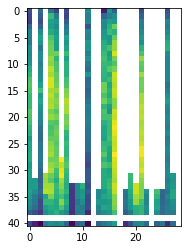

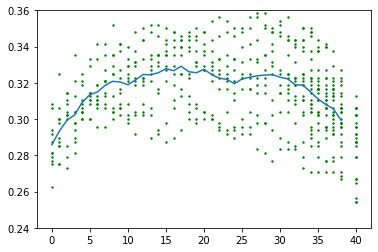

In [180]:
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import subprocess
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

roiloc="schaefer2018"
dataSource="neurosketch"
subjects=glob("./wang2014/[0,1]*")
subjects=[subject.split("/")[-1] for subject in subjects]
subjects=subjects_correctly_aligned
# subjects=["0111171"]
N=40
GreedyBestAcc=np.zeros((len(subjects),N+1))
for ii,subject in enumerate(subjects):
    try:
        GreedyBestAcc[ii,40]=np.load("./{}/{}/output/top{}.npy".format(roiloc, subject, N))
    except:
        pass
            
    for len_topN_1 in range(N-1,0,-1):
#         Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
#             print(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            di = load_obj(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}")
            GreedyBestAcc[ii,len_topN_1-1] = di['bestAcc']
        except:
            pass
GreedyBestAcc=GreedyBestAcc.T
GreedyBestAcc[GreedyBestAcc==0]=None
plt.imshow(GreedyBestAcc)
_=plt.figure()
for i in range(GreedyBestAcc.shape[0]):
    plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i],c='g',s=2)
plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
plt.ylim([0.24,0.36])
# plt.xlabel("number of ROIs")
# plt.ylabel("accuracy")

Text(0, 0.5, 'accuracy')

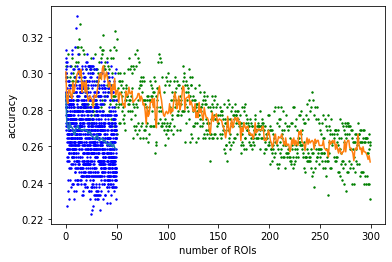

In [135]:

# code to load and compare the result of above:
# SummaryAccuracy.py
from glob import glob
import numpy as np
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"

subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=""
for sub in subs:
    subjects=subjects+sub+" "


testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects=subs #["0110171", "0110172", "0111171"]
hemis=["lh", "rh"]
subs=subjects_correctly_aligned
wangAcc=np.zeros((50,len(subs)))
roiloc="wang2014"
for sub_i,sub in enumerate(subjects):
    for num in range(1,51):
        try:
            wangAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={wangAcc[num-1,sub_i]}")
        except:
            pass

schaeferAcc=np.zeros((300,3))
roiloc="schaefer2018"
for sub_i,sub in enumerate(subjects):
    for num in range(1,301):
        try:
            schaeferAcc[num-1,sub_i]=np.load(f"{testDir}{roiloc}/{sub}/output/top{num}.npy")
#             print(f"{roiloc} {sub} {num} ROIs acc={schaeferAcc[num-1,sub_i]}")
        except:
            pass


wangAcc=wangAcc[:,wangAcc[0]!=0]
schaeferAcc=schaeferAcc[:,schaeferAcc[0]!=0]
schaeferAcc[schaeferAcc==0]=None

import matplotlib.pyplot as plt
plt.plot(np.nanmean(wangAcc,axis=1))
plt.plot(np.nanmean(schaeferAcc,axis=1))


for i in range(schaeferAcc.shape[0]):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
for i in range(wangAcc.shape[0]):
    plt.scatter([i]*wangAcc.shape[1],wangAcc[i],c='b',s=2)

plt.xlabel("number of ROIs")
plt.ylabel("accuracy")

(0.24, 0.36)

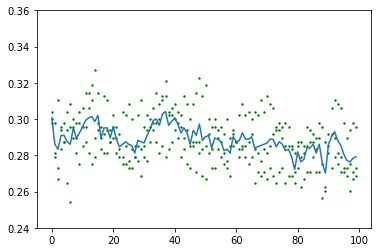

In [137]:
for i in range(100):
    plt.scatter([i]*schaeferAcc.shape[1],schaeferAcc[i],c='g',s=2)
plt.plot(np.nanmean(schaeferAcc[:100,:],axis=1))
plt.ylim([0.24,0.36])

In [35]:
!pwd

/gpfs/milgram/pi/turk-browne/projects/rtTest


NameError: name 'subjects' is not defined

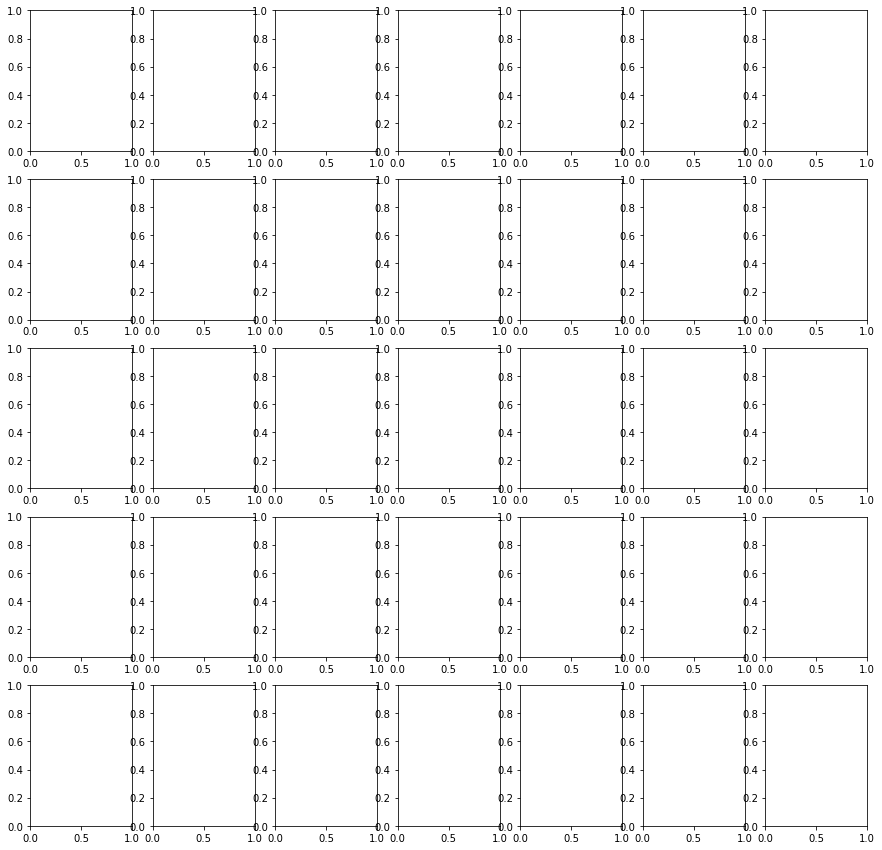

In [13]:
import nibabel as nib
import matplotlib.pyplot as plt
fig,axs=plt.subplots(5,7,figsize=(15,15))
axs=axs.reshape(-1)
for ii,sub in enumerate(subjects):
    STAND="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz"


    ROIpath="/gpfs/milgram/scratch/turk-browne/tsy6/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI"
    WANG2FUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wang2func.mat"
    TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/${sub}_neurosketch_recognition_run_1.nii.gz"
    TEMPLATE_bet=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/neurosketch_recognition_run_1_bet.nii.gz"

    WANGINFUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wanginfunc.nii.gz"

#     fslview_deprecated  ${WANGINFUNC} ${TEMPLATE_bet}
    
    
    template_bet=nib.load(TEMPLATE_bet).get_data()
    axs[ii].imshow(template_bet[int(template_bet.shape[0]/2),:,:])
    axs[ii].set_title(ii+1)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


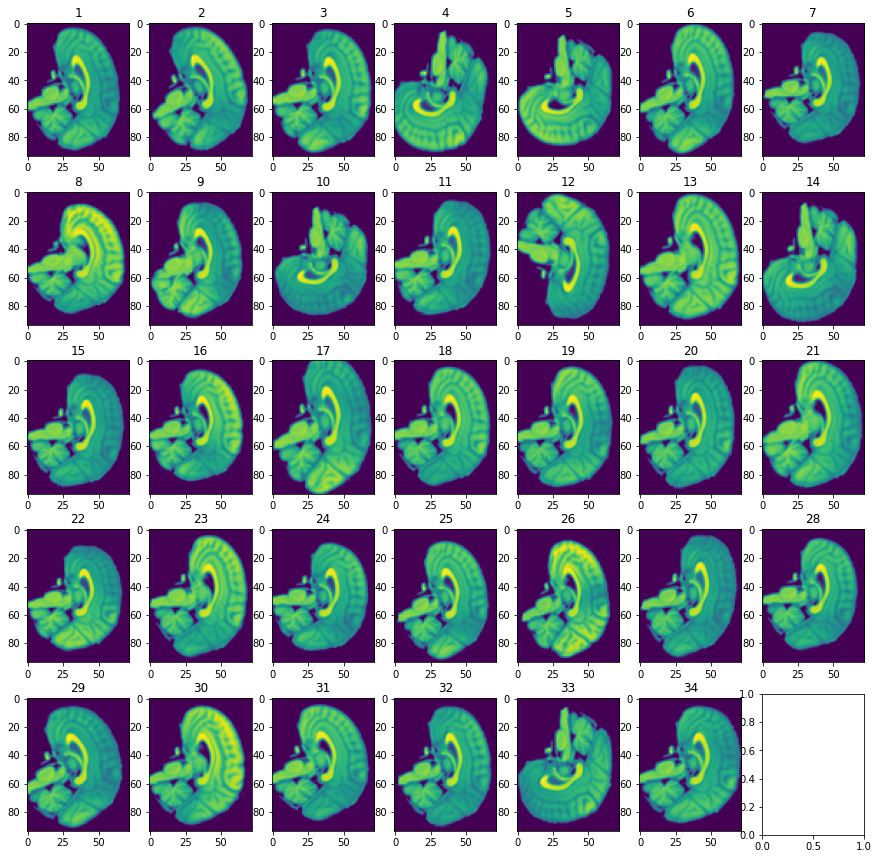

In [128]:
import nibabel as nib
fig,axs=plt.subplots(5,7,figsize=(15,15))
axs=axs.reshape(-1)
for ii,sub in enumerate(subjects):
    STAND="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz"


    ROIpath="/gpfs/milgram/scratch/turk-browne/tsy6/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI"
    WANG2FUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wang2func.mat"
    TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/${sub}_neurosketch_recognition_run_1.nii.gz"
    TEMPLATE_bet=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/neurosketch_recognition_run_1_bet.nii.gz"

    WANGINFUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wanginfunc.nii.gz"

#     fslview_deprecated  ${WANGINFUNC} ${TEMPLATE_bet}
    
    
#     template_bet=nib.load(TEMPLATE_bet).get_data()
#     axs[ii].imshow(template_bet[int(template_bet.shape[0]/2),:,:])
    wanginfunc=nib.load(WANGINFUNC).get_data()
    axs[ii].imshow(wanginfunc[int(wanginfunc.shape[0]/2),:,:])

    axs[ii].set_title(ii+1)


In [1]:
# get subjects_correctly_aligned
from glob import glob
import numpy as np
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"

subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=""
for sub in subs:
    subjects=subjects+sub+" "


testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects=subs

subjects_correctly_aligned=[]
for ii,sub in enumerate(subjects):
    if (ii+1) in [1,2,3,6,7,8,9,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34]:
        subjects_correctly_aligned.append(sub)
len(subjects_correctly_aligned)

29

In [139]:
# di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"
from glob import glob
from subprocess import call
import os
import sys
# subs=glob(f"{di}[0,1]*_neurosketch")
# subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
#subjects="1206161 0119173 1206162 1201161 0115174 1130161 1206163 0120171 0111171 1202161 1121161 0125172 0110172 0123173 0120172 0113171 0115172 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0119171 0117171 0119174 0112173 0112174 0125171 0112172"
subjects="0110171 1207162 0118171 1206163 0123173 0119174 0119173 0120171 1202161 0117171 0124171 0120173 1121161 0125172 0112173 1206162 0112171 0112174 1130161 0123171 0110172 0112172 1203161 0115172 1206161 0118172 0119172 0111171 1201161"
subjects=subjects.split(" ")

testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'

# for curr_roi in range(1,1+25):
#     mask=[]
#     command="fslmaths "
#     for sub in subjects:
#         file=f"./wang2014/{sub}/output/STAND_top{curr_roi}mask.nii.gz"
#         path="/gpfs/milgram/project/turk-browne/projects/rtTest/"
#         if os.path.exists(path+file):
#             command=command+file+" -add "
#     command=command[:-6]
#     command=command+f' ./wang2014/sumMask_{curr_roi}.nii.gz'
#     if curr_roi==2:
#         print(command)
# #         call(command,shell=True)

print("     \n\n\n")
for curr_roi in range(1,1+300):
    mask=[]
    command="fslmaths "
    for sub in subjects:
        file=f"./schaefer2018/{sub}/output/STAND_top{curr_roi}mask.nii.gz"
        path="/gpfs/milgram/project/turk-browne/projects/rtTest/"
        if os.path.exists(path+file):
            command=command+file+" -add "
    command=command[:-6]
    command=command+f' ./schaefer2018/sumMask_{curr_roi}.nii.gz'
    if curr_roi==38:
        print(command)
#         call(command,shell=True)

     



fslmaths ./schaefer2018/1206163/output/STAND_top38mask.nii.gz -add ./schaefer2018/0119173/output/STAND_top38mask.nii.gz -add ./schaefer2018/0120171/output/STAND_top38mask.nii.gz -add ./schaefer2018/1206162/output/STAND_top38mask.nii.gz -add ./schaefer2018/1130161/output/STAND_top38mask.nii.gz -add ./schaefer2018/1206161/output/STAND_top38mask.nii.gz -add ./schaefer2018/0111171/output/STAND_top38mask.nii.gz ./schaefer2018/sumMask_38.nii.gz


In [ ]:
# fslview_deprecated  ./schaefer2018/sumMask_38.nii.gz  /gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz # looks bad

In [164]:
import pandas as pd
ROIs=[]
for sub in subjects_correctly_aligned:
    try:
        data=pd.read_csv(f"schaefer2018/{sub}/output/top38.csv")
        ROIs=ROIs+list(data['0'])[:-1]
    except:
        pass

In [170]:
# ROIs=np.unique(ROIs)

sub ="1201161"

for pn, parc in enumerate(ROIs):
    _mask = nib.load("./{}/{}/{}".format(roiloc, sub, parc))
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
#     mask[mask>0] = 1

savemask = nib.Nifti1Image(mask, affine=aff)
nib.save(savemask, f"./top{38}mask.nii.gz")

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


In [ ]:
fslview_deprecated top38mask.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1201161/neurosketch_recognition_run_1_bet.nii.gz

In [2]:
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/")
!pwd
# get subjects_correctly_aligned
from glob import glob
import numpy as np
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"

subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=""
for sub in subs:
    subjects=subjects+sub+" "


testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects=subs

subjects_correctly_aligned=[]
for ii,sub in enumerate(subjects):
    if (ii+1) in [1,2,3,6,7,8,9,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34]:
        subjects_correctly_aligned.append(sub)
len(subjects_correctly_aligned)

/gpfs/milgram/pi/turk-browne/projects/rtTest


29

In [7]:
# the brighter means the ROI was used in multiple subjects

# Load the top38 for the subjects_correctly_aligned.

import numpy as np
import nibabel as nib
import os
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
ROIs=[]
roiloc='wang2014'# roiloc = "schaefer2018"
for sub in subjects_correctly_aligned:
    try:
        data=pd.read_csv(f"{roiloc}/{sub}/output/top38.csv")
        ROIs=ROIs+list(data['0'])[:-1]
    except:
        pass

sub ="1201161"

for pn, parc in enumerate(ROIs):
    _mask = nib.load("./{}/{}/{}".format(roiloc, sub, parc))
    aff = _mask.affine
    _mask = _mask.get_data()
    _mask = _mask.astype(int)
    # say some things about the mask.
    mask = _mask if pn == 0 else mask + _mask
#     mask[mask>0] = 1

savemask = nib.Nifti1Image(mask, affine=aff)
nib.save(savemask, f"./{roiloc}_top{38}mask.nii.gz")


# fslview_deprecated wang2014_top38mask.nii.gz /gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/1201161/neurosketch_recognition_run_1_bet.nii.gz


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


In [8]:
import numpy as np
import nibabel as nib
import os
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression

import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/")
!pwd
# get subjects_correctly_aligned
from glob import glob



# # How to align orientation:
# realtime_ornt=nib.orientations.axcodes2ornt(('I', 'P', 'L'))
# ref_ornt=nib.orientations.axcodes2ornt(('P', 'S', 'L'))
# global ornt_transform
# ornt_transform = nib.orientations.ornt_transform(realtime_ornt,ref_ornt)

# temp_data = niftiObject.get_data()
# output_image_correct = nib.orientations.apply_orientation(temp_data, ornt_transform)
# correct_object = new_img_like(templateFunctionalVolume, output_image_correct, copy_header=True)
# correct_object.to_filename(fullNiftiFilename)


/gpfs/milgram/pi/turk-browne/projects/rtTest


In [30]:
import os
from nilearn.image import new_img_like
# from nibabel.testing import data_path
data_path="/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/0110171/"


func = os.path.join(data_path, 'neurosketch_recognition_run_1_bet.nii.gz')

def print_orien(example_file):
    img = nib.load(example_file)
    # Here is the affine (to two digits decimal precision):
    np.set_printoptions(precision=2, suppress=True)
    # print(f"img.affine={img.affine}")
    # What are the orientations of the voxel axes here?
    # Nibabel has a routine to tell you, called aff2axcodes.
    orientation = nib.aff2axcodes(img.affine)
    print(f"orientation={orientation}")
    return nib.aff2axcodes(img.affine)

orientation_func = print_orien(func)

stand="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz"
orientation_stand = print_orien(stand)






orientation=('L', 'P', 'S')
orientation=('L', 'A', 'S')


In [23]:

def orien_trans(stand,func,stand_funcOrien):
    orientation_func = print_orien(func)
    orientation_stand = print_orien(stand)
    
    # convert stand brain to functional space
    stand_data = nib.load(stand).get_data()
    ornt_transform = nib.orientations.ornt_transform(
        nib.orientations.axcodes2ornt(orientation_stand),
        nib.orientations.axcodes2ornt(orientation_func))
    stand_funcOrien = nib.orientations.apply_orientation(stand_data, ornt_transform)
    correct_object = new_img_like(func,stand_funcOrien, copy_header=True)
    correct_object.to_filename(stand_funcOrien)
stand_funcOrien="stand_funcOrien.nii.gz"
orien_trans(stand,func,stand_funcOrien)

/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


In [26]:



# nib.save(output_image_correct, 'stand_funcOrien.nii.gz')


In [27]:
orientation_func = print_orien(func)
orientation_stand = print_orien("stand_funcOrien.nii.gz")






img.affine=[[ -2.04   0.    -0.01  95.14]
 [  0.    -2.01  -0.38  90.2 ]
 [ -0.01  -0.39   1.96 -32.83]
 [  0.     0.     0.     1.  ]]
orientation=('L', 'P', 'S')
img.affine=[[ -2.04   0.    -0.01  95.14]
 [  0.    -2.01  -0.38  90.2 ]
 [ -0.01  -0.39   1.96 -32.83]
 [  0.     0.     0.     1.  ]]
orientation=('L', 'P', 'S')


In [31]:
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/")
!pwd
# get subjects_correctly_aligned
from glob import glob
import numpy as np
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"

subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=""
for sub in subs:
    subjects=subjects+sub+" "


testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects=subs
for sub in subjects:
    TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_1.nii.gz"
    print_orien(TEMPLATE)

/gpfs/milgram/pi/turk-browne/projects/rtTest
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'A', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')
orientation=('L', 'P', 'S')


In [11]:
# import os
# os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/")
# !pwd

# stand="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz" 
# TEMPLATE_bet="./../wang2014/1121161/neurosketch_recognition_run_1_bet.nii.gz"
# stand_funcOrien="./1121161/wang_funcOrien.nii.gz"

# import os
# print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 

# import numpy as np
# import nibabel as nib
# import os
# import sys
# import time
# from nilearn.image import new_img_like
# # sys.path.append('/gpfs/milgram/project/turk-browne/users/kp578/realtime/rt-cloud/')

# def print_orien(example_file):
#     img = nib.load(example_file)
#     # Here is the affine (to two digits decimal precision):
#     np.set_printoptions(precision=2, suppress=True)
#     # print(f"img.affine={img.affine}")
#     # What are the orientations of the voxel axes here?
#     # Nibabel has a routine to tell you, called aff2axcodes.
#     orientation = nib.aff2axcodes(img.affine)
#     print(f"orientation of {example_file} = {orientation}")
#     return nib.aff2axcodes(img.affine)

# def orien_trans(stand,func,stand_funcOrien):
#     orientation_func = print_orien(func)
#     orientation_stand = print_orien(stand)
    
#     # convert stand brain to functional space
#     stand_data = nib.load(stand).get_data()
#     ornt_transform = nib.orientations.ornt_transform(
#         nib.orientations.axcodes2ornt(orientation_stand),
#         nib.orientations.axcodes2ornt(orientation_func))
#     stand_funcOrien = nib.orientations.apply_orientation(stand_data, ornt_transform)
#     correct_object = new_img_like(func,stand_funcOrien, copy_header=True)
#     correct_object.to_filename(stand_funcOrien)


# # orien_trans(stand,TEMPLATE_bet,stand_funcOrien)
# stand,func,stand_funcOrien_fileName=stand,TEMPLATE_bet,stand_funcOrien
# orientation_func = print_orien(func)
# orientation_stand = print_orien(stand)

# # convert stand brain to functional space
# stand_data = nib.load(stand).get_data()
# ornt_transform = nib.orientations.ornt_transform(
#     nib.orientations.axcodes2ornt(orientation_stand),
#     nib.orientations.axcodes2ornt(orientation_func))
# stand_funcOrien = nib.orientations.apply_orientation(stand_data, ornt_transform)
# correct_object = new_img_like(func,stand_funcOrien, copy_header=True)
# correct_object.to_filename(stand_funcOrien_fileName)


/gpfs/milgram/pi/turk-browne/projects/rtTest/wang2014
conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
orientation of ./../wang2014/1121161/neurosketch_recognition_run_1_bet.nii.gz = ('L', 'P', 'S')
orientation of /gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz = ('L', 'A', 'S')


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


/gpfs/milgram/pi/turk-browne/projects/rtTest


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


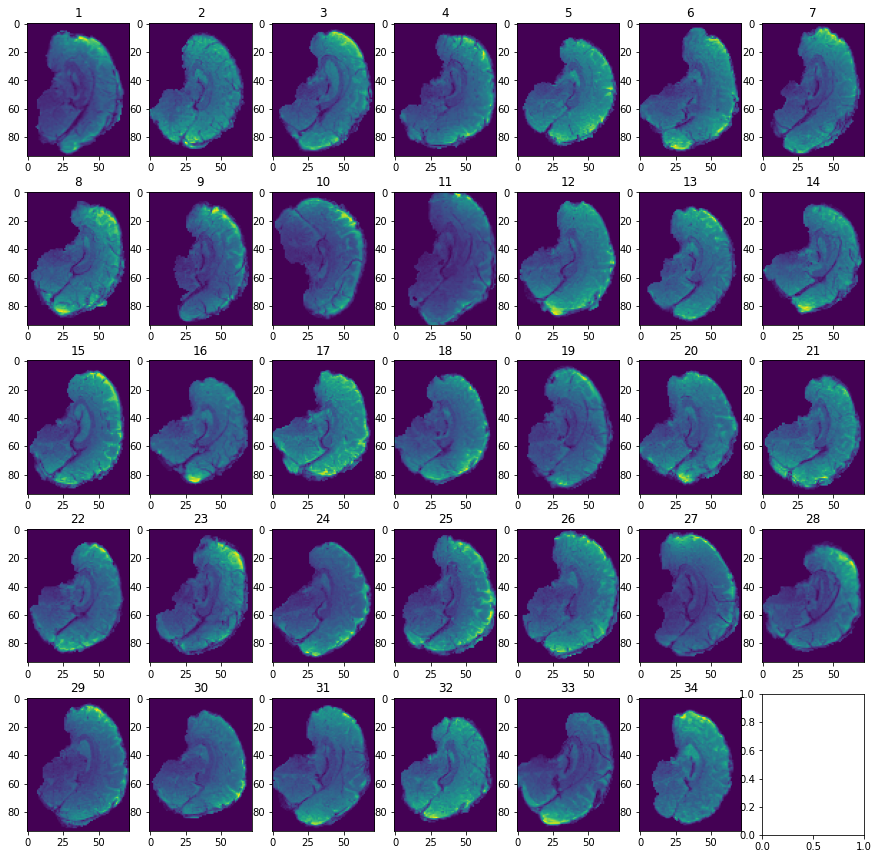

In [1]:
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/")
!pwd
# get subjects_correctly_aligned
from glob import glob
import numpy as np
di="/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/"

subs=glob(f"{di}[0,1]*_neurosketch")
subs=[sub.split("/")[-1].split("_")[0] for sub in subs]
subjects=""
for sub in subs:
    subjects=subjects+sub+" "


testDir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
subjects=subs


import nibabel as nib
import matplotlib.pyplot as plt
fig,axs=plt.subplots(5,7,figsize=(15,15))
axs=axs.reshape(-1)
for ii,sub in enumerate(subjects):
    STAND="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz"


    ROIpath="/gpfs/milgram/scratch/turk-browne/tsy6/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI"
    WANG2FUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wang2func.mat"
    TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/${sub}_neurosketch_recognition_run_1.nii.gz"
    TEMPLATE_bet=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/neurosketch_recognition_run_1_bet.nii.gz"

    WANGINFUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wanginfunc.nii.gz"

#     fslview_deprecated  ${WANGINFUNC} ${TEMPLATE_bet}
    
    
    template_bet=nib.load(TEMPLATE_bet).get_data()
    axs[ii].imshow(template_bet[int(template_bet.shape[0]/2),:,:])
    axs[ii].set_title(ii+1)


/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


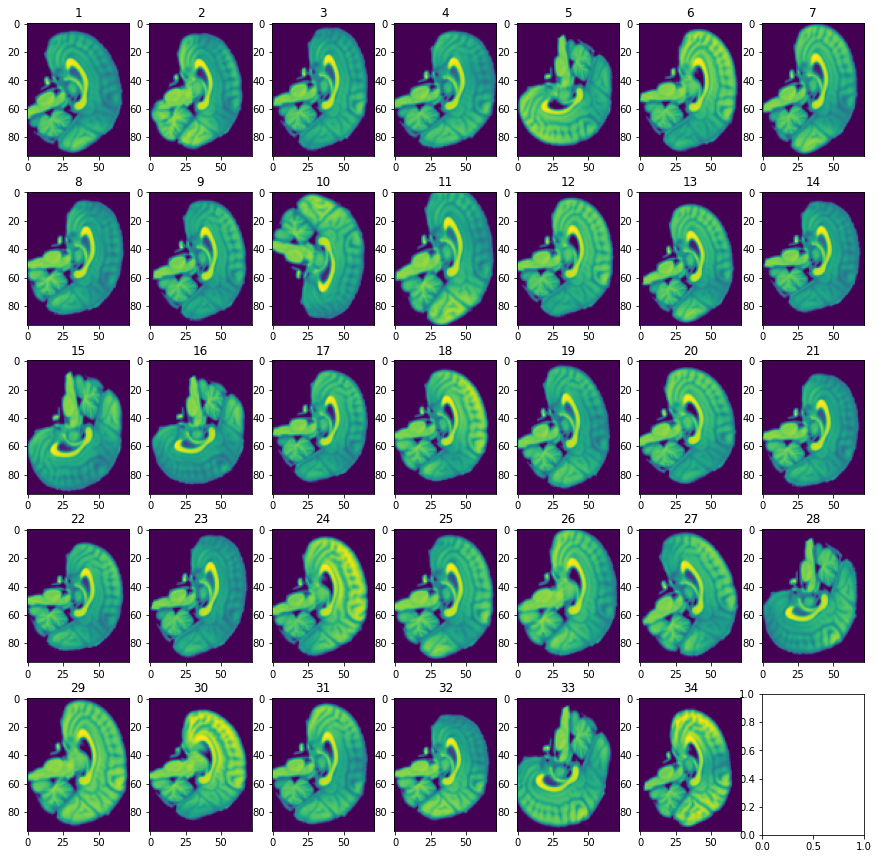

In [14]:
fig,axs=plt.subplots(5,7,figsize=(15,15))
axs=axs.reshape(-1)
for ii,sub in enumerate(subjects):
    STAND="/gpfs/milgram/apps/hpc.rhel7/software/FSL/5.0.10-centos7_64/data/standard/MNI152_T1_1mm_brain.nii.gz"


    ROIpath="/gpfs/milgram/scratch/turk-browne/tsy6/CBIG/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI"
    WANG2FUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wang2func.mat"
    TEMPLATE=f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/${sub}_neurosketch_recognition_run_1.nii.gz"
    TEMPLATE_bet=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/neurosketch_recognition_run_1_bet.nii.gz"
    stand_funcOrien=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wang_funcOrien.nii.gz"
    WANGINFUNC=f"/gpfs/milgram/project/turk-browne/projects/rtTest/wang2014/{sub}/wanginfunc.nii.gz"
#     TEMPLATE_bet stand_funcOrien
#     fslview_deprecated  ${WANGINFUNC} ${TEMPLATE_bet}
    
    
    template_bet=nib.load(WANGINFUNC).get_data()
    axs[ii].imshow(template_bet[int(template_bet.shape[0]/2),:,:])
    axs[ii].set_title(ii+1)


In [13]:
subjects_correctly_aligned=[]
for ii,sub in enumerate(subjects):
    if ii+1 in [5,15,16,28,33]:
#         print(sub,end=' ')
        pass
    else:
        print(f"{sub}','",end='')
        subjects_correctly_aligned.append(sub)

1206161','0119173','1206162','1201161','1130161','1206163','0120171','0111171','1202161','1121161','0125172','0110172','0123173','0115172','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112174','0112172','

In [9]:
subjects_correctly_aligned

['1206161',
 '0119173',
 '1206162',
 '1201161',
 '1130161',
 '1206163',
 '0120171',
 '0111171',
 '1202161',
 '1121161',
 '0125172',
 '0110172',
 '0123173',
 '0115172',
 '0120173',
 '0110171',
 '0119172',
 '0124171',
 '0123171',
 '1203161',
 '0118172',
 '0118171',
 '0112171',
 '1207162',
 '0117171',
 '0119174',
 '0112173',
 '0112174',
 '0112172']

In [ ]:
'''
purpose:
    according to the given number of ROIs N, pick up the top N ROIs accuracy and combine them for a combined mask and retrain the model and getting result

steps:
    load accuracy for all the ROIs for given subject
    pick up the top N ROIs
    combine these top N masks
    retrain the model and get the accuracy.

    get the N combinations of N-1 ROIs
    retrain the model and get the accuracy for these N combinations

    get the N-1 combinations of N-2 ROIs
    retrain the model and get the accuracy for these N-1 combinations

'''
'''
you could try to see whether combining parcels improves performance. 
That's going to be the most important bit, because we'll want to decide on a tradeoff between number of voxels and accuracy. 
The script of interest here is aggregate.sh which is just a feeder for aggregate.py. 
This will use the .npy outputs of classRegion.py to select and merge the top N ROIs/parcels, and will return the list of ROI names, the number of voxels, and the cross-validated classifier accuracy 
in this newly combined larger mask. An example run of this is as follows:
sbatch aggregate.sh 0111171 neurosketch schaefer2018 15
'''
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
# from tqdm import tqdm
import pickle
import subprocess
from subprocess import call
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# What subject are you running
'''
Takes args (in order):
    subject (e.g. 0111171)
    dataSource (e.g. neurosketch, but also realtime)
    roiloc (wang2014 or schaefer2018)
    N (the number of parcels or ROIs to start with)
'''

subject,dataSource,roiloc,N="0111171","neurosketch", "schaefer2018",116

print("Running subject {}, with {} as a data source, {}, starting with {} ROIs".format(subject, dataSource, roiloc, N))


# dataSource depending, there are a number of keywords to fill in: 
# ses: which day of data collection
# run: which run number on that day (single digit)
# phase: 12, 34, or 56
# sub: subject number
if dataSource == "neurosketch":
    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
elif dataSource == "realtime":
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
    anat = "$TO_BE_FILLED"
else:
    funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
    anat = "$TO_BE_FILLED"


workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
starttime = time.time()
# '1201161', '1121161','0115172','0112174' #these subject have nothing in output folder
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
if roiloc == "schaefer2018":
    RESULT=np.empty((len(subjects_correctly_aligned),300))
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for roinum in range(1,301):
            result = np.load("{}/{}.npy".format(outloc, roinum))
            RESULT[ii,roinum-1]=result
            # RESULT = result if roinum == 1 else np.vstack((RESULT, result))
    RESULT = np.mean(RESULT,axis=0)
    print(f"RESULT.shape={RESULT.shape}")
    RESULTix = RESULT[:].argsort()[-N:]
    for idx in RESULTix:
        topN.append("{}.nii.gz".format(idx+1))
        # print(topN[-1])
else:
    RESULT_all=[]
    topN = []
    for ii,sub in enumerate(subjects_correctly_aligned):
        outloc = workingDir+"/{}/{}/output".format(roiloc, sub)
        for hemi in ["lh", "rh"]:
            for roinum in range(1, 26):
                result = np.load("{}/roi{}_{}.npy".format(outloc, roinum, hemi))
                Result = result if roinum == 1 else np.vstack((Result, result))
            RESULT = Result if hemi == "lh" else np.hstack((RESULT, Result))
        RESULT_all.append(RESULT)

    RESULT_all=np.asarray(RESULT_all)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT_all=np.mean(RESULT_all,axis=0)
    print(f"RESULT_all.shape={RESULT_all.shape}")
    RESULT1d = RESULT.flatten()
    RESULTix = RESULT1d.argsort()[-N:]
    x_idx, y_idx = np.unravel_index(RESULTix, RESULT.shape)

    # Check that we got the largest values.
    for x, y, in zip(x_idx, y_idx):
        print(x,y)
        if y == 0:
            topN.append("roi{}_lh.nii.gz".format(x+1))
        else:
            topN.append("roi{}_rh.nii.gz".format(x+1))
        # print(topN[-1])

print(f"len(topN)={len(topN)}")
print(f"topN={topN}")

def Wait(waitfor, delay=1):
    while not os.path.exists(waitfor):
        time.sleep(delay)
        print('waiting for {}'.format(waitfor))
        
def normalize(X):
    X = X - X.mean(3)
    return X

def Class(data, bcvar):
    metas = bcvar[0]
    data4d = data[0]
    print(data4d.shape)

    accs = []
    for run in range(6):
        testX = data4d[run]
        testY = metas[run]
        trainX = data4d[np.arange(6) != run]
        trainX = trainX.reshape(trainX.shape[0]*trainX.shape[1], -1)
        trainY = []
        for meta in range(6):
            if meta != run:
                trainY.extend(metas[run])
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                 multi_class='multinomial').fit(trainX, trainY)
                
        # Monitor progress by printing accuracy (only useful if you're running a test set)
        acc = clf.score(testX, testY)
        accs.append(acc)
    
    return np.mean(accs)


phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

mask=getMask(topN, subject)

print('mask dimensions: {}'. format(mask.shape))
print('number of voxels in mask: {}'.format(np.sum(mask)))

# Compile preprocessed data and corresponding indices
metas = []

for run in range(1, 7):
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_data()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    # features = features[:, mask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    features = features - featmean
    features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    metas.append(labels)
    runs = features if run == 1 else np.concatenate((runs, features))

dimsize = runIm.header.get_zooms()


# Preset the variables
print("Runs shape", runs.shape)
bcvar = [metas]

In [17]:
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
!pwd

save_obj([bcvar,runs],f"./tmp/{subject}_{dataSource}_{roiloc}_{N}") #{len(topN)}_{i}
                 
# # Distribute the information to the searchlights (preparing it to run)
# _runs = [runs[:,:,mask==1]]
# print("Runs shape", _runs[0].shape)
# slstart = time.time()
# sl_result = Class(_runs, bcvar)
# print("results of classifier: {}, type: {}".format(sl_result, type(sl_result)))
# SL = time.time() - slstart
# tot = time.time() - starttime
# print('total time: {}, searchlight time: {}'.format(tot, SL))

def wait(tmpFile):
    while not os.path.exists(tmpFile+'_result.npy'):
        time.sleep(5)
        print(f"waiting for {tmpFile}+'_result.npy'\n")
    return np.load(tmpFile+'_result.npy')

def numOfRunningJobs():
    # subprocess.Popen(['squeue -u kp578 | wc -l > squeue.txt'],shell=True) # sl_result = Class(_runs, bcvar)
    randomID=str(time.time())
    # print(f"squeue -u kp578 | wc -l > squeue/{randomID}.txt")
    call(f'squeue -u kp578 | wc -l > squeue/{randomID}.txt',shell=True)
    numberOfJobsRunning = int(open(f"squeue/{randomID}.txt", "r").read())
    print(f"numberOfJobsRunning={numberOfJobsRunning}")
    return numberOfJobsRunning
                
# ./tmp/0125171_40_schaefer2018_neurosketch_39.pkl
if os.path.exists(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{1}.pkl"):
    print(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_1.pkl exists")
    raise Exception('runned or running')

# N-1
def next(topN):
    print(f"len(topN)={len(topN)}")
    print(f"topN={topN}")

    if len(topN)==1:
        return None
    else:
        try:
            allpairs = itertools.combinations(topN,len(topN)-1)
            topNs=[]
            sl_results=[]
            tmpFiles=[]
            while os.path.exists("./tmp/holdon.npy"):
                time.sleep(10)
                print("sleep for 10s ; waiting for ./tmp/holdon.npy to be deleted")
            np.save("./tmp/holdon",1)

            for i,_topN in enumerate(allpairs):
                tmpFile=f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}_{i}"
                print(f"tmpFile={tmpFile}")
                topNs.append(_topN)
                tmpFiles.append(tmpFile)

                if not os.path.exists(tmpFile+'_result.npy'):

                    # prepare brain data(runs) mask and behavior data(bcvar) 
                    
                    # save_obj([_runs,bcvar], tmpFile)
                    save_obj([_topN,subject,dataSource,roiloc,N], tmpFile)

                    print("kp2")
                    numberOfJobsRunning = numOfRunningJobs()
                    print("kp3")
                    while numberOfJobsRunning > 110:
                        print("kp4")
                        print("waiting 10, too many jobs running") ; time.sleep(10)
                        numberOfJobsRunning = numOfRunningJobs()
                        print("kp5")

                    # get the evidence for the current mask
                    print(f'sbatch class.sh {tmpFile}')
                    proc = subprocess.Popen([f'sbatch class.sh {tmpFile}'],shell=True) # sl_result = Class(_runs, bcvar) 
                    print("kp6")
                else:
                    print(tmpFile+'_result.npy exists!')
            os.remove("./tmp/holdon.npy")

            sl_results=[]
            for tmpFile in tmpFiles:
                sl_result=wait(tmpFile)
                sl_results.append(sl_result)
            print(f"sl_results={sl_results}")
            print(f"max(sl_results)=={max(sl_results)}")
            maxID=np.where(sl_results==max(sl_results))[0][0]
            save_obj({"subject":subject,
            "startFromN":N,
            "currNumberOfROI":len(topN)-1,
            "bestAcc":max(sl_results),
            "bestROIs":topNs[maxID]},
            f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}"
            )
            print(f"bestAcc={max(sl_results)} For {len(topN)-1} = ./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)-1}")
            tmpFiles=next(topNs[maxID])
        except:
            return tmpFiles
tmpFiles=next(topN)

/gpfs/milgram/pi/turk-browne/projects/rtTest/kp_scratch
len(topN)=116
topN=['284.nii.gz', '226.nii.gz', '230.nii.gz', '59.nii.gz', '296.nii.gz', '204.nii.gz', '19.nii.gz', '68.nii.gz', '197.nii.gz', '25.nii.gz', '30.nii.gz', '253.nii.gz', '89.nii.gz', '185.nii.gz', '179.nii.gz', '36.nii.gz', '241.nii.gz', '34.nii.gz', '239.nii.gz', '291.nii.gz', '134.nii.gz', '124.nii.gz', '87.nii.gz', '240.nii.gz', '15.nii.gz', '189.nii.gz', '97.nii.gz', '193.nii.gz', '268.nii.gz', '31.nii.gz', '208.nii.gz', '106.nii.gz', '149.nii.gz', '199.nii.gz', '121.nii.gz', '298.nii.gz', '116.nii.gz', '1.nii.gz', '142.nii.gz', '299.nii.gz', '139.nii.gz', '183.nii.gz', '281.nii.gz', '14.nii.gz', '111.nii.gz', '21.nii.gz', '74.nii.gz', '178.nii.gz', '71.nii.gz', '18.nii.gz', '198.nii.gz', '257.nii.gz', '75.nii.gz', '227.nii.gz', '132.nii.gz', '145.nii.gz', '153.nii.gz', '293.nii.gz', '280.nii.gz', '275.nii.gz', '214.nii.gz', '154.nii.gz', '236.nii.gz', '190.nii.gz', '93.nii.gz', '271.nii.gz', '209.nii.gz', '113.ni

In [20]:
allpairs = itertools.combinations(topN,len(topN)-1)
topNs=[]
sl_results=[]
tmpFiles=[]

for i,_topN in enumerate(allpairs):
    tmpFile=f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len(topN)}_{i}"
    print(f"tmpFile={tmpFile}")
    topNs.append(_topN)
    tmpFiles.append(tmpFile)

    if not os.path.exists(tmpFile+'_result.npy'):

        # prepare brain data(runs) mask and behavior data(bcvar) 

        # save_obj([_runs,bcvar], tmpFile)
        save_obj([_topN,subject,dataSource,roiloc,N], tmpFile)

        print("kp2")
        numberOfJobsRunning = numOfRunningJobs()
        print("kp3")
        while numberOfJobsRunning > 110:
            print("kp4")
            print("waiting 10, too many jobs running") ; time.sleep(10)
            numberOfJobsRunning = numOfRunningJobs()
            print("kp5")

        # get the evidence for the current mask
        print(f'sbatch class.sh {tmpFile}')
        proc = subprocess.Popen([f'sbatch class.sh {tmpFile}'],shell=True) # sl_result = Class(_runs, bcvar) 
        print("kp6")
    else:
        print(tmpFile+'_result.npy exists!')

tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_0
./tmp/0111171_116_schaefer2018_neurosketch_116_0_result.npy exists!
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_1
./tmp/0111171_116_schaefer2018_neurosketch_116_1_result.npy exists!
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_2
./tmp/0111171_116_schaefer2018_neurosketch_116_2_result.npy exists!
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_3
./tmp/0111171_116_schaefer2018_neurosketch_116_3_result.npy exists!
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_4
./tmp/0111171_116_schaefer2018_neurosketch_116_4_result.npy exists!
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_5
./tmp/0111171_116_schaefer2018_neurosketch_116_5_result.npy exists!
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_6
./tmp/0111171_116_schaefer2018_neurosketch_116_6_result.npy exists!
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_7
./tmp/0111171_116_schaefer2018_neurosketch_116_7_result.npy exists!


numberOfJobsRunning=103
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_55
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_56
kp2
numberOfJobsRunning=104
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_56
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_57
kp2
numberOfJobsRunning=105
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_57
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_58
kp2
numberOfJobsRunning=105
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_58
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_59
kp2
numberOfJobsRunning=106
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_59
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_60
kp2
numberOfJobsRunning=107
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_60
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_61
kp2
numberOfJobsRunning=108
kp3
sbatch class

numberOfJobsRunning=106
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_107
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_108
kp2
numberOfJobsRunning=107
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_108
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_109
kp2
numberOfJobsRunning=108
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_109
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_110
kp2
numberOfJobsRunning=109
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_110
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_111
kp2
numberOfJobsRunning=110
kp3
sbatch class.sh ./tmp/0111171_116_schaefer2018_neurosketch_116_111
kp6
tmpFile=./tmp/0111171_116_schaefer2018_neurosketch_116_112
kp2
numberOfJobsRunning=111
kp3
kp4
waiting 10, too many jobs running


KeyboardInterrupt: 